In [27]:
# Importing Libraries

import pandas as pd
import geopandas as gpd
import numpy as np
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as colors

import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


In [28]:
def filter_by_country(df, country):
    if 'country_name' not in df.columns:
        return df
    return df[df['country_name'] == country]

def get_property_by_code(code):
    return f'{observations[observations["code"] == code]["property"].values[0]} ({code})'

# observations dataset
observations = pd.read_csv('./data/WoSIS_2023_December/wosis_202312_observations.tsv', sep='\t')

# codes list
codes = ["BDFI33", "BDFIAD", "BDFIFM", "BDFIOD", "BDWSOD", "CECPH7", "CECPH8", "CFGR", "CFVO", "CLAY", "ECEC", "ELCO20", "ELCO25", "ELCO50", "ELCOSP", "NITKJD", "ORGC", "ORGM", "PHAQ", "PHCA", "PHETB1", "PHETM3", "PHETOL", "PHKC", "PHNF", "PHPRTN", "PHPTOT", "PHPWSL", "SAND", "SILT", "TCEQ", "TOTC", "WG0006", "WG0010", "WG0033", "WG0100", "WG0200", "WG0500", "WG1500", "WV0010", "WV0033", "WV0100", "WV0500", "WV1500"]

base_path = './data/WoSIS_2023_December/wosis_202312_'

valid_codes = []
orgc_df = pd.DataFrame() # will be used for testing single code

from datetime import datetime
import os
os.makedirs(f'./outputs/plots/{datetime.now().strftime("%Y%m%d")}', exist_ok=True)

""" # mexico coordinates
min_lat, max_lat = 14.5388286402, 32.72083
min_lon, max_lon = -118.45, -86.811982388

# plot the coordinates using folium
mexico_map = folium.Map(location=[23.6345, -102.5528], zoom_start=5)
folium.Rectangle(bounds=[[min_lat, min_lon], [max_lat, max_lon]], color='red', fill=True).add_to(mexico_map)
mexico_map
 """

" # mexico coordinates\nmin_lat, max_lat = 14.5388286402, 32.72083\nmin_lon, max_lon = -118.45, -86.811982388\n\n# plot the coordinates using folium\nmexico_map = folium.Map(location=[23.6345, -102.5528], zoom_start=5)\nfolium.Rectangle(bounds=[[min_lat, min_lon], [max_lat, max_lon]], color='red', fill=True).add_to(mexico_map)\nmexico_map\n "

In [29]:
# # load mexico geojson
# mexico_geojson = gpd.read_file('./data/mexico_.geojson')
# # mexico_geojson.geometry.head()

# from shapely.geometry import Point

# for filename in codes:
#     df = pd.read_csv(f'{base_path}{filename.lower()}.tsv', sep='\t')
#     df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
#     df = gpd.GeoDataFrame(df, geometry='geometry')

#     mexico_df = filter_by_country(df, 'Mexico')

#     # use mexico geojson to get the bounding box
#     bounding_box = mexico_geojson.unary_union
#     print(bounding_box)

#     # Filter records that fall within the Mexico geometry
#     records_within_mexico = df[df.geometry.intersects(bounding_box)]

#     # num of records
#     print(f'{filename} Country: {len(mexico_df)} Coordinates: {len(records_within_mexico)}')

In [30]:
# from shapely.geometry import Point

# for filename in codes:
#     df = pd.read_csv(f'{base_path}{filename.lower()}.tsv', sep='\t')
#     df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
#     df = gpd.GeoDataFrame(df, geometry='geometry')

#     mexico_df = filter_by_country(df, 'Mexico')

#     bounding_box = df.cx[min_lon:max_lon, min_lat:max_lat]

#     # num of records
#     print(f'{filename} Country: {len(mexico_df)} Coordinates: {len(bounding_box)}')


In [31]:
for filename in codes:
    df = pd.read_csv(f'{base_path}{filename.lower()}.tsv', sep='\t')

    df = filter_by_country(df, 'Mexico')
    property = get_property_by_code(filename)
        
    if df is False:
        print(f'\033[91mCountry name not found for {property}\033[0m')
        continue

    if df.empty:
        print(f'\033[93mEmpty mexico records for {property}\033[0m')
        continue

    # count missing values for country_name
    missing_values = df['country_name'].isnull().sum()
    if missing_values > 0:
        print(f'Missing country name for {filename}: {missing_values}')

    # Add to valid codes list
    valid_codes.append(filename)

    if filename == 'ORGC':
        orgc_df = df

print("\n")
print(f'Codes list: {valid_codes}')
print(f'Codes length: {len(valid_codes)}')

Empty mexico records for Bulk density fine earth (BDFIAD)
Empty mexico records for Bulk density fine earth (BDFIFM)
Empty mexico records for Cation exchange capacity (CECPH8)
Empty mexico records for Electrical conductivity (ELCO25)
Empty mexico records for Electrical conductivity (ELCO50)
Empty mexico records for Organic matter (ORGM)
Empty mexico records for Phosphorus (P) (PHETM3)
Empty mexico records for Phosphorus (P) (PHETOL)
Empty mexico records for Phosphorus (P) (PHPTOT)
Empty mexico records for Phosphorus (P) (PHPWSL)
Empty mexico records for Water retention gravimetric (WG0100)
Empty mexico records for Water retention gravimetric (WG0500)
Empty mexico records for Water retention volumetric (WV0010)
Empty mexico records for Water retention volumetric (WV0033)
Empty mexico records for Water retention volumetric (WV0100)
Empty mexico records for Water retention volumetric (WV0500)
Empty mexico records for Water retention volumetric (WV1500)


Codes list: ['BDFI33', 'BDFIOD', 'B

### Observation:

Loss of data after being filtered by country (Mexico) left with 21 features for analysis.

In [32]:
# folium map
mexico_map = folium.Map(location=[23.6345, -102.5528], zoom_start=5)

# mexico shapefile
world = gpd.GeoDataFrame.from_file('./data/geovectors/ne_110m_admin_0_countries.shp')
mexico_shape = world[world['NAME'] == 'Mexico']

### Pre processing
Data is pre processed to remove missing values, negative values and outliers.

### Observation
- Distribution of data is inconsistent for each property.
- Some properties have a long tail distribution.
- Because this is geographical data we cannot consider the data to be evenly distributed.
- Very few data points are available for some properties.


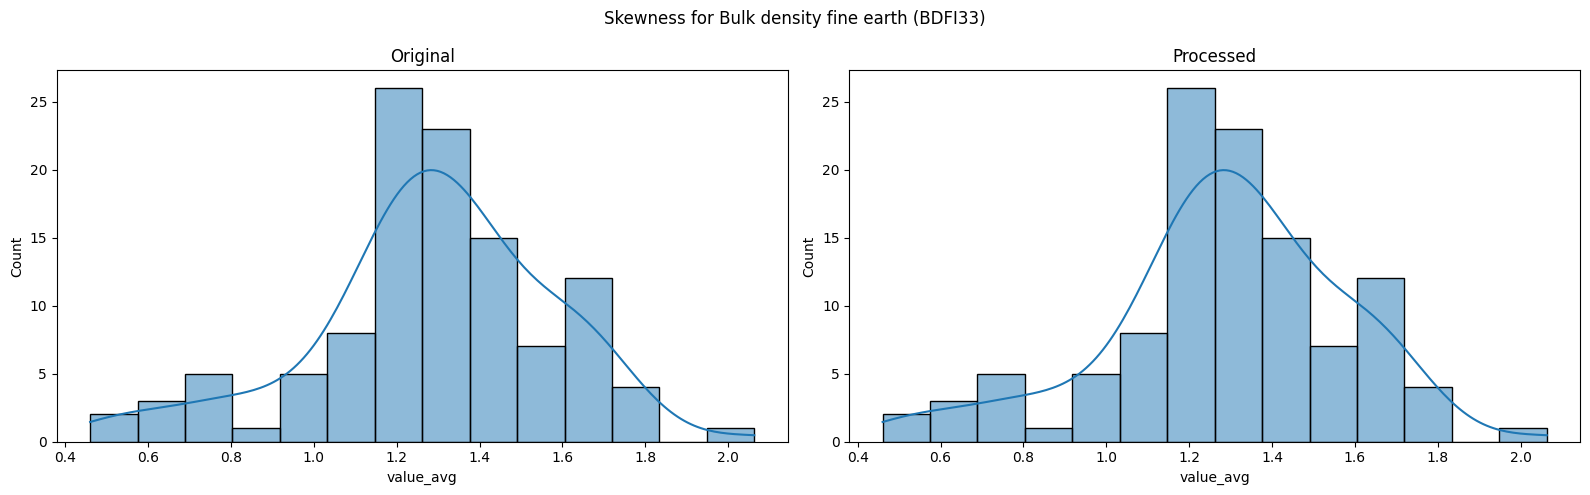

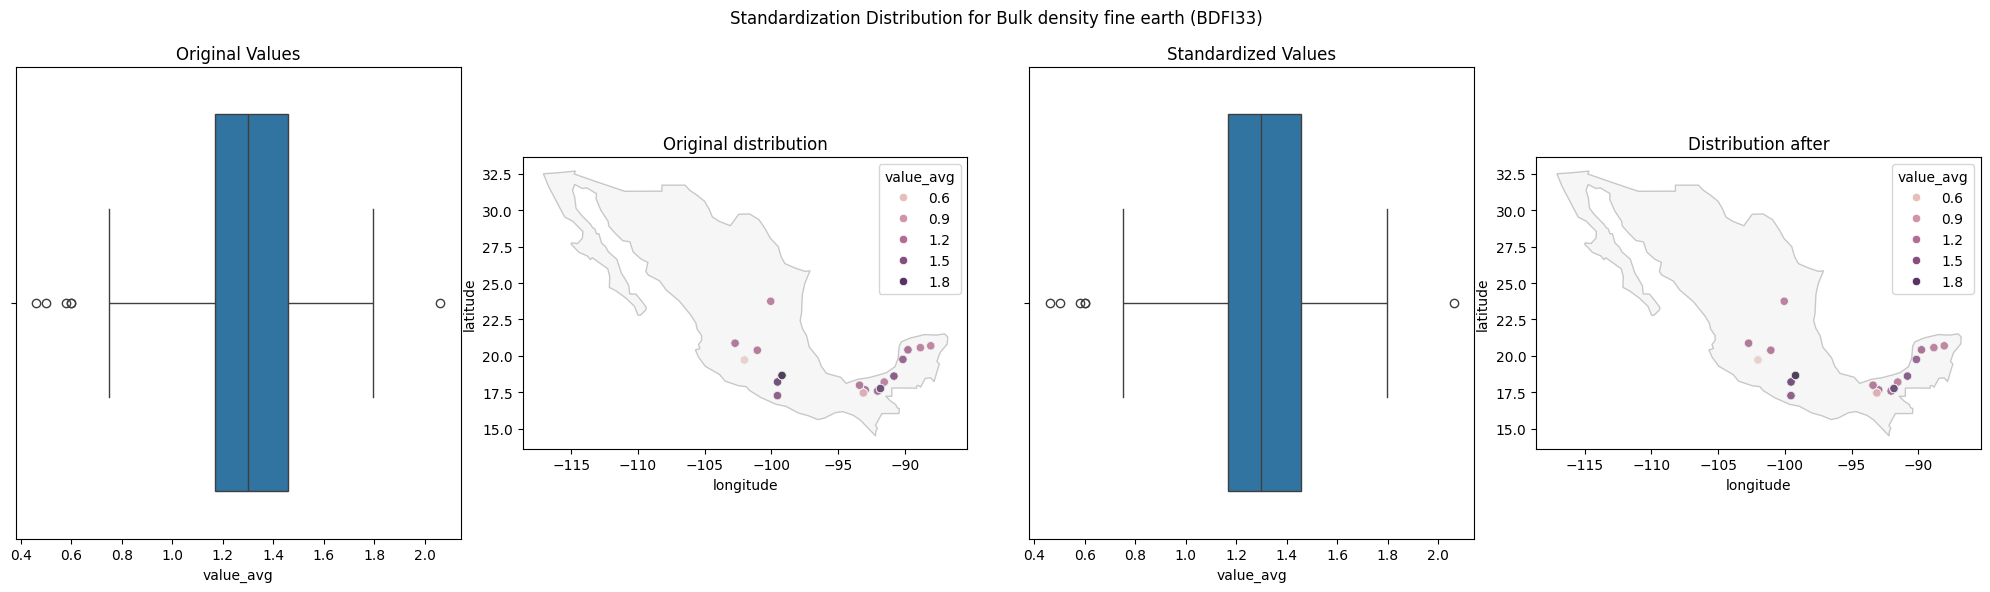

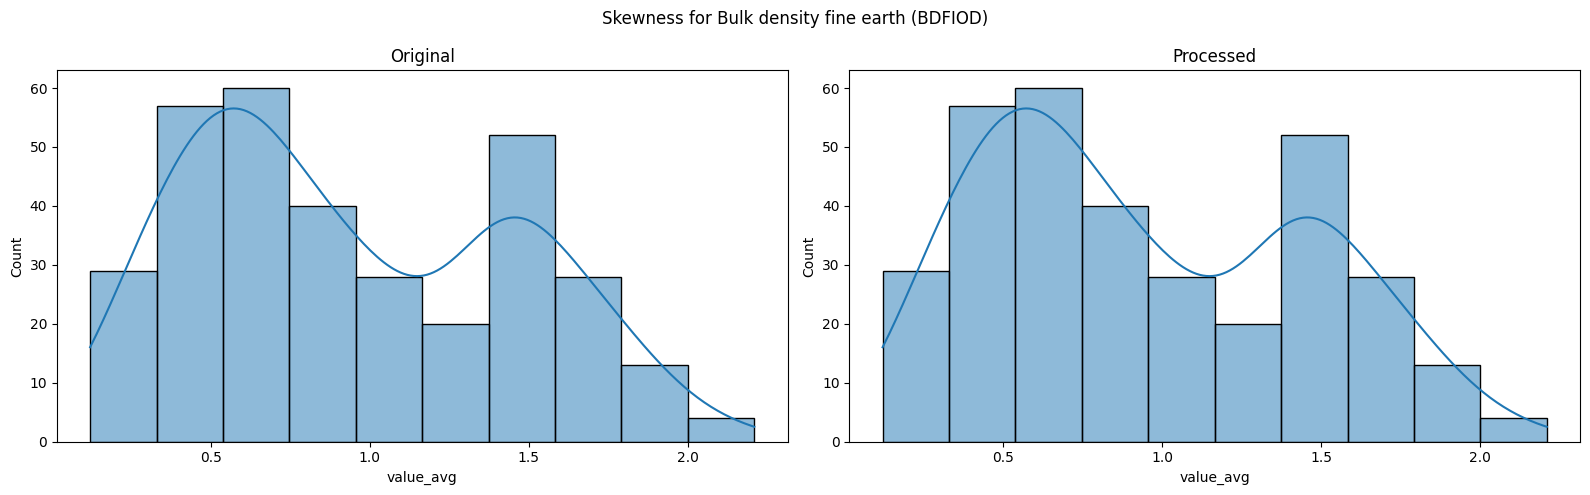

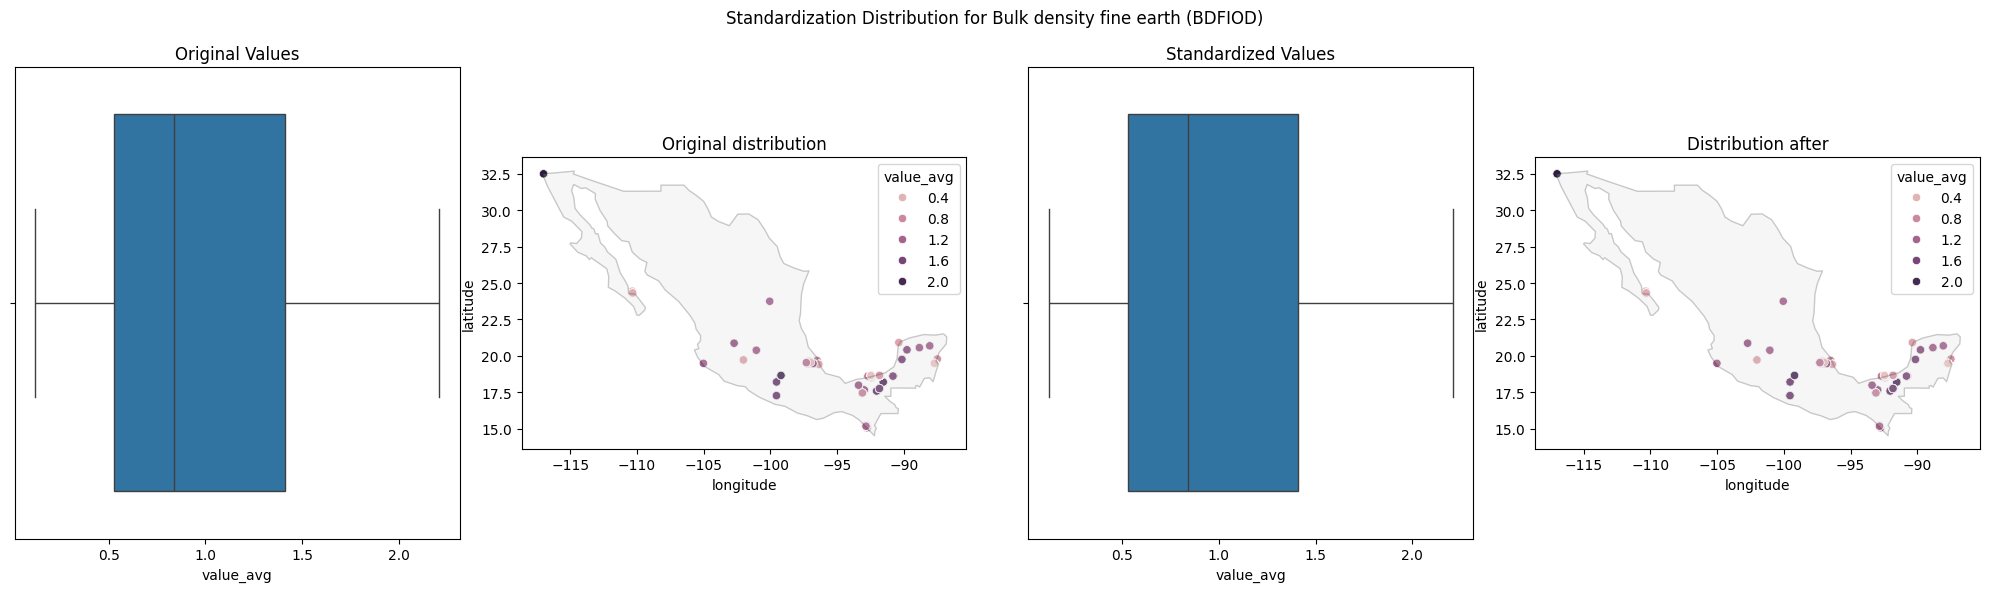

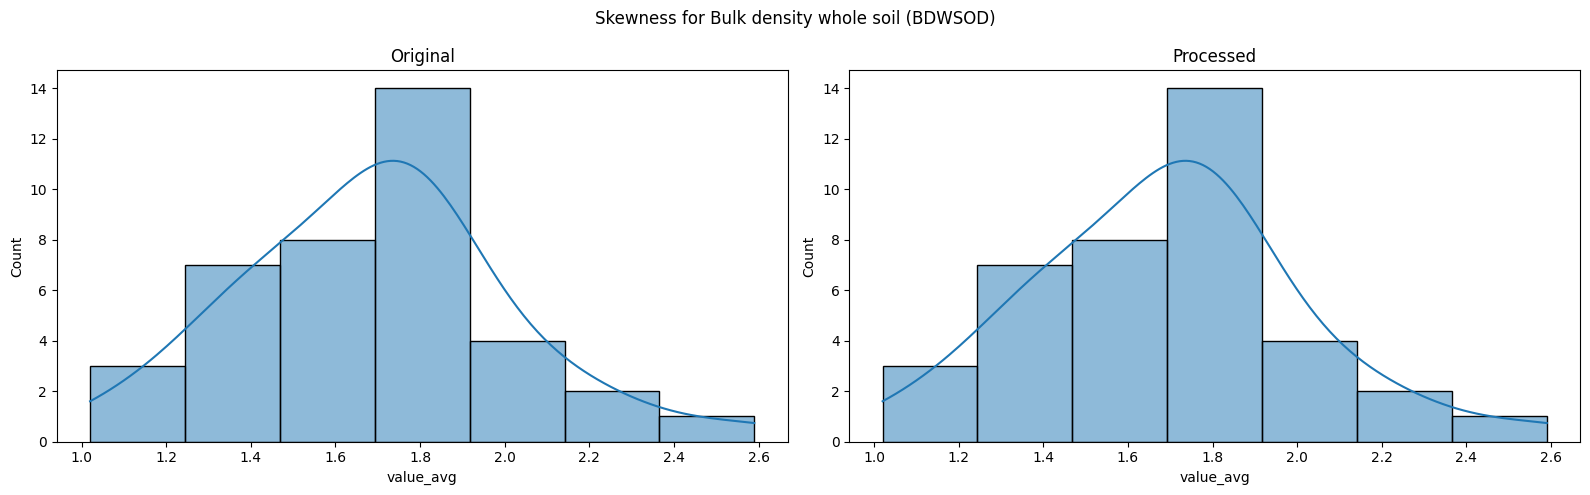

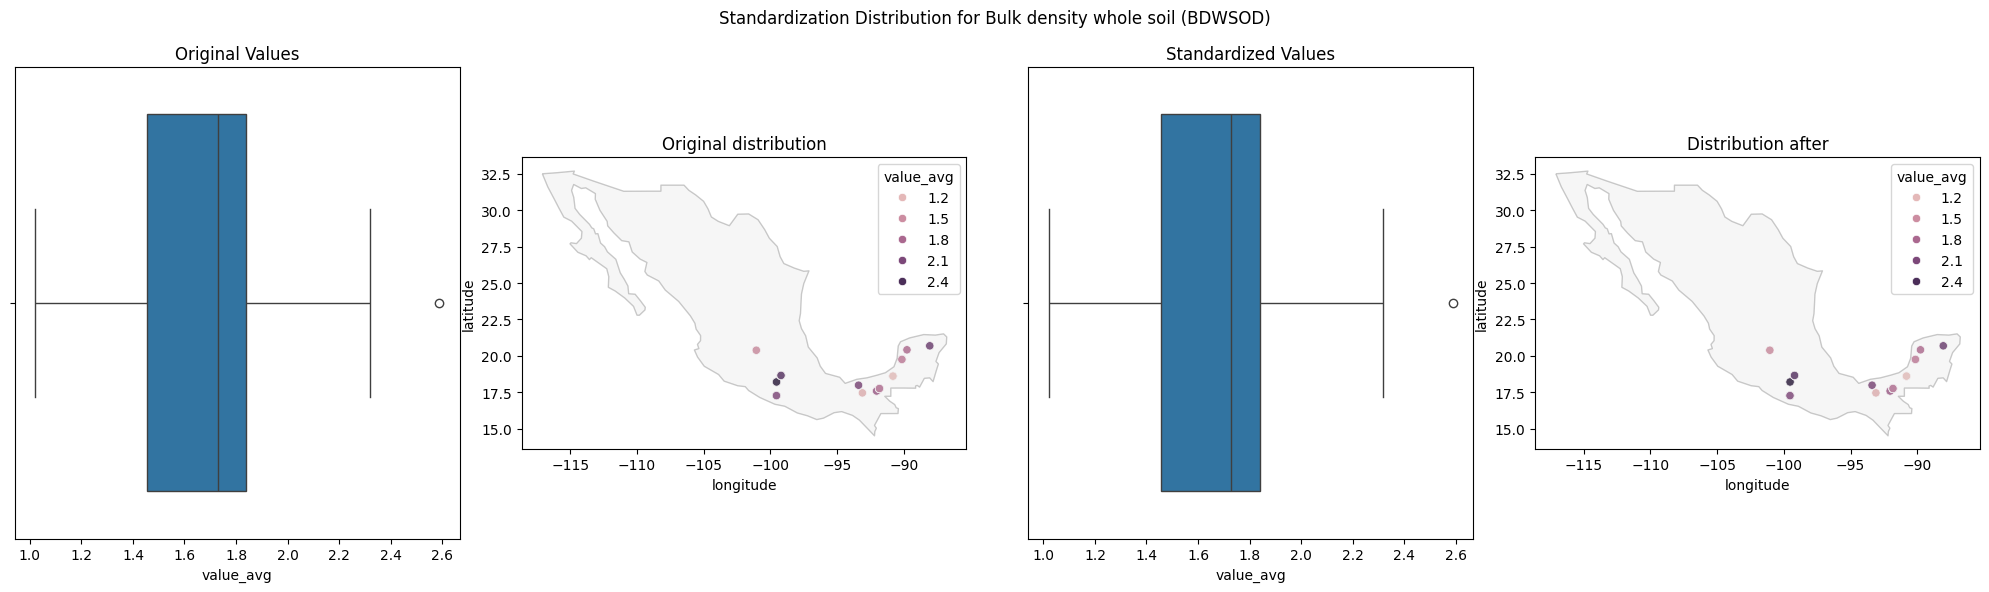

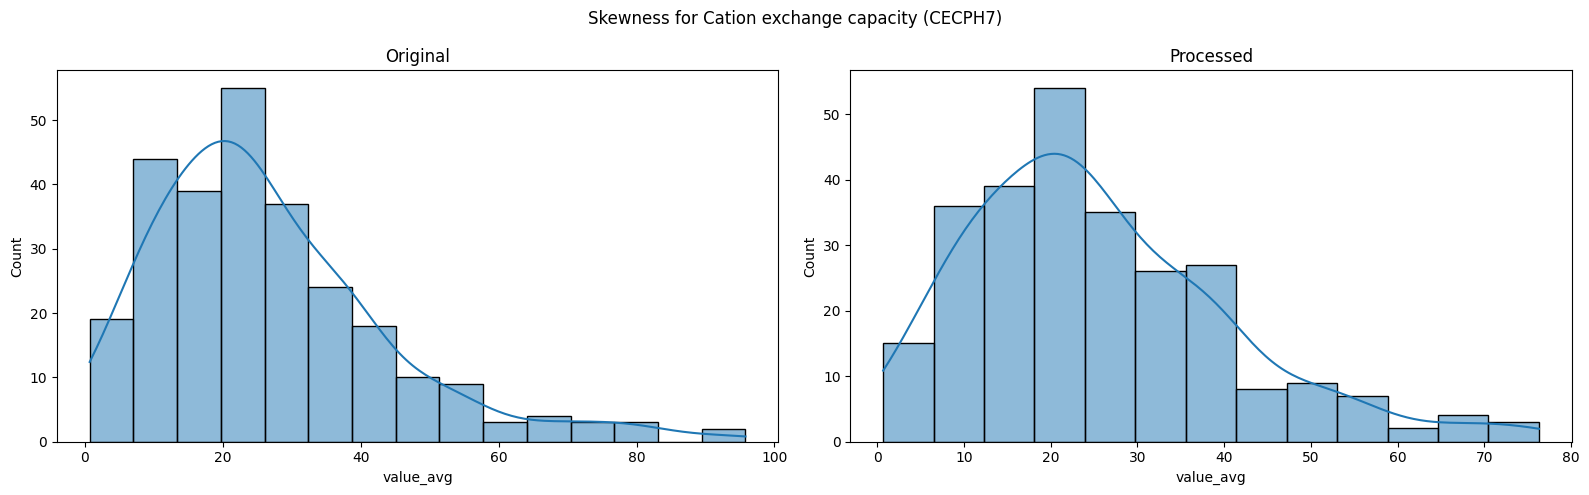

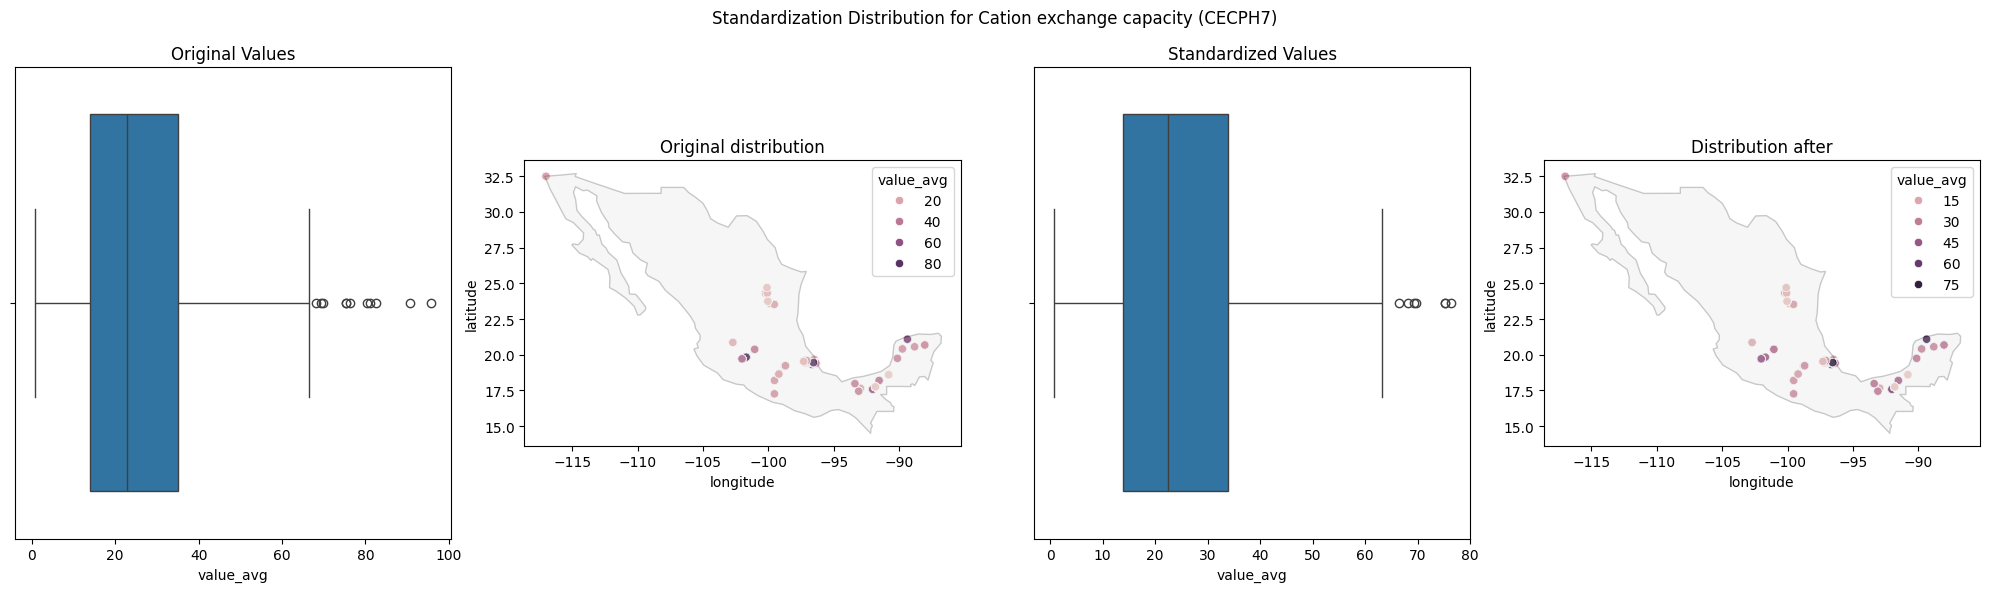

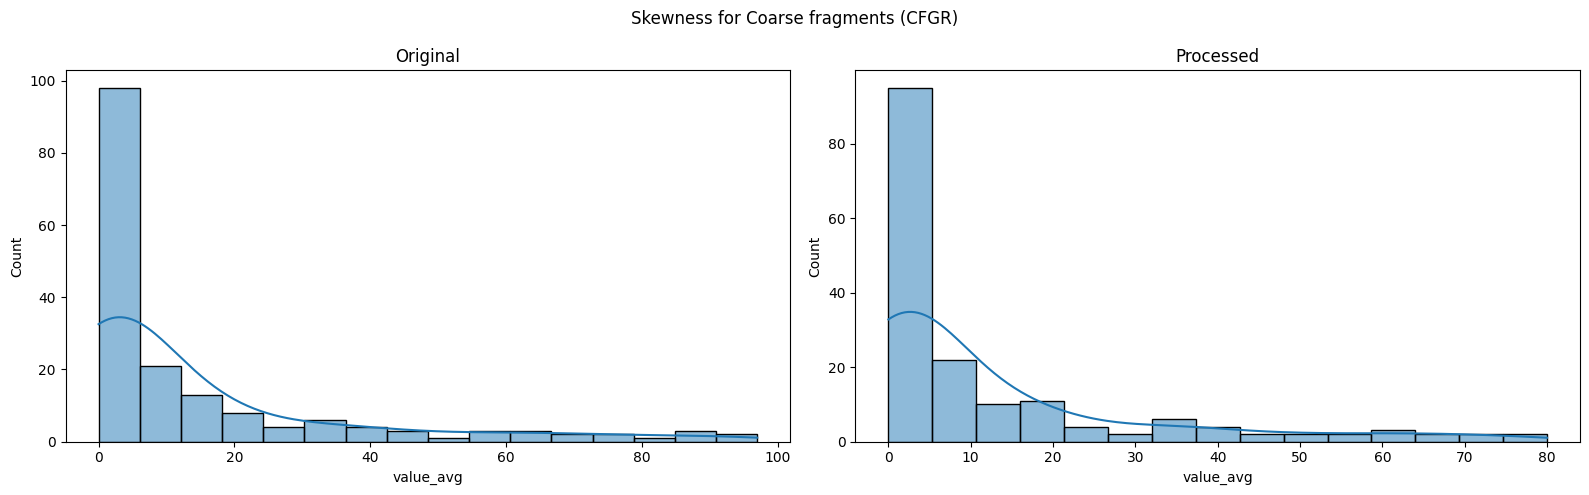

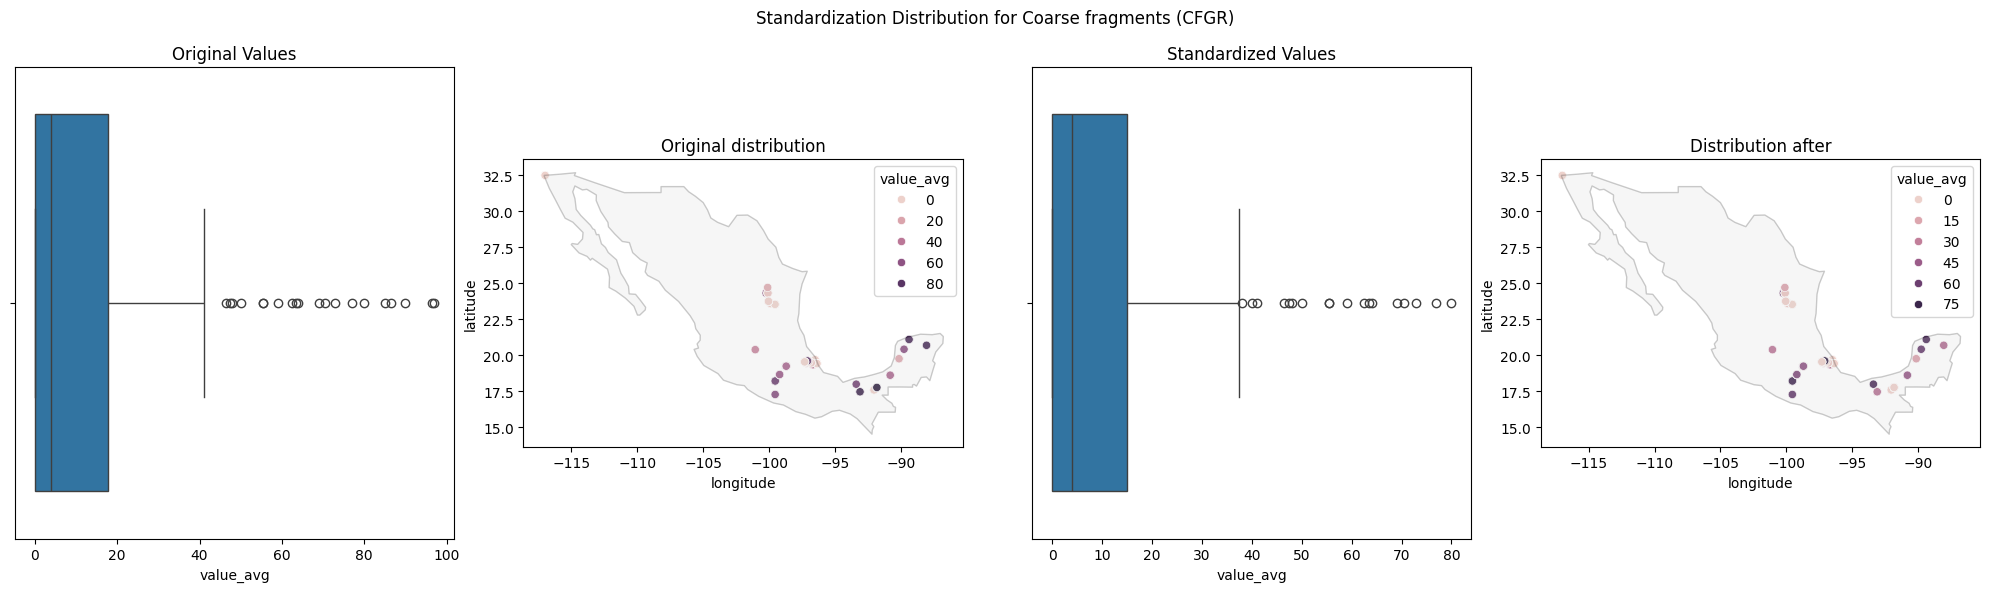

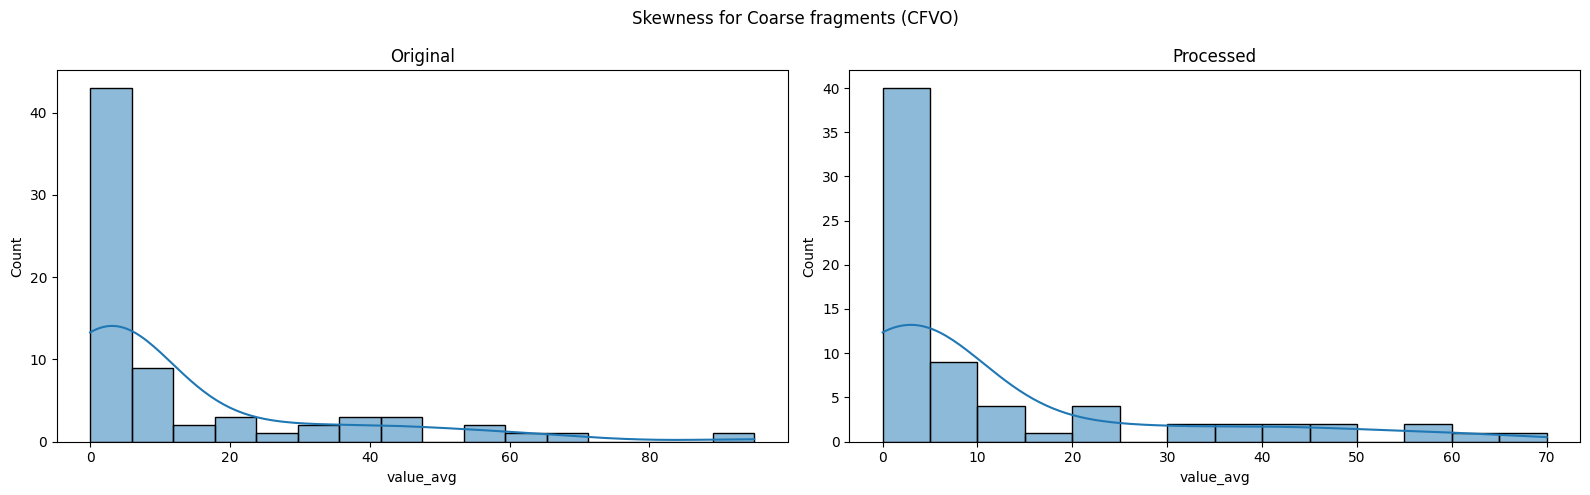

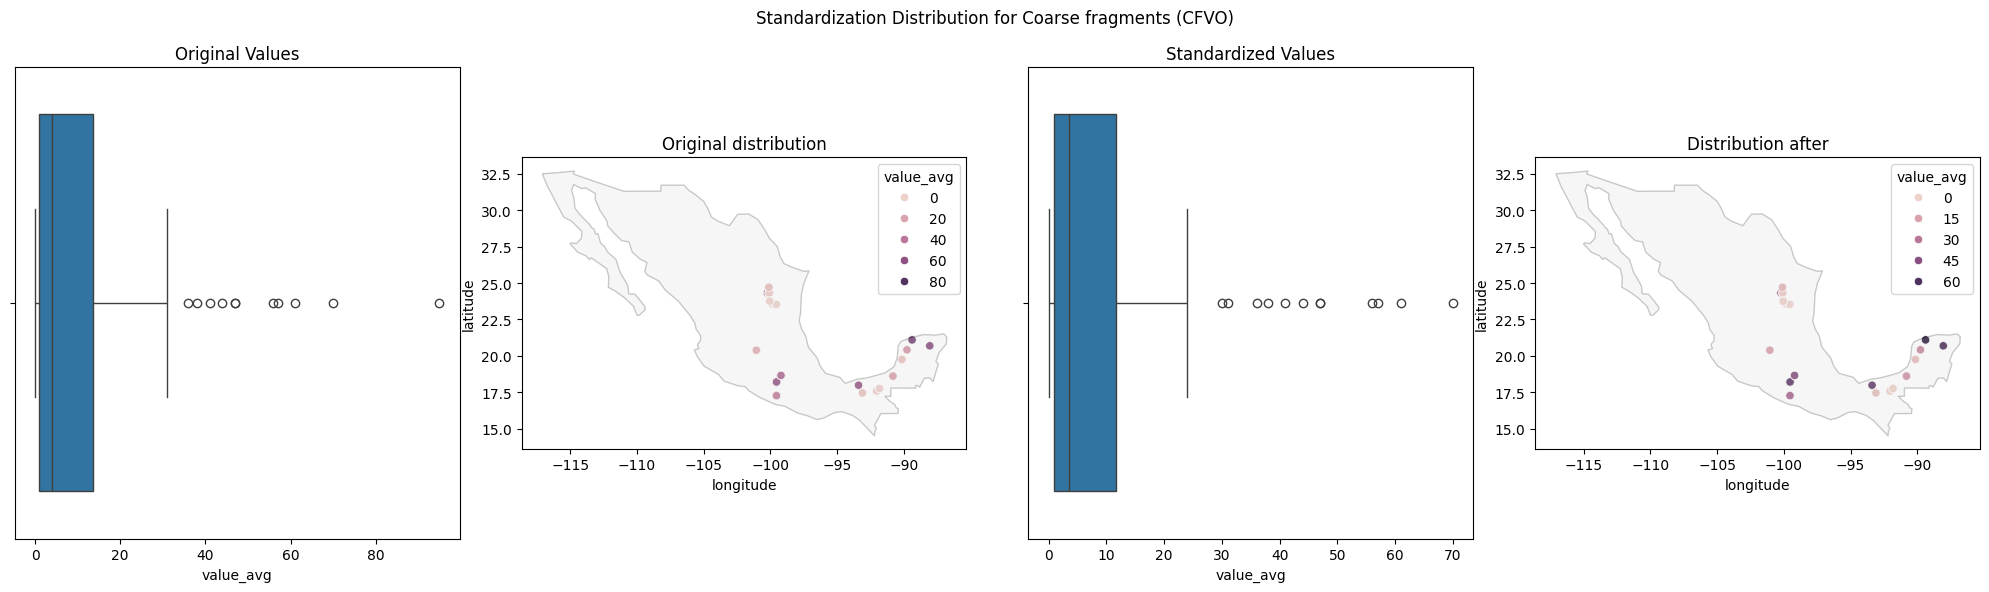

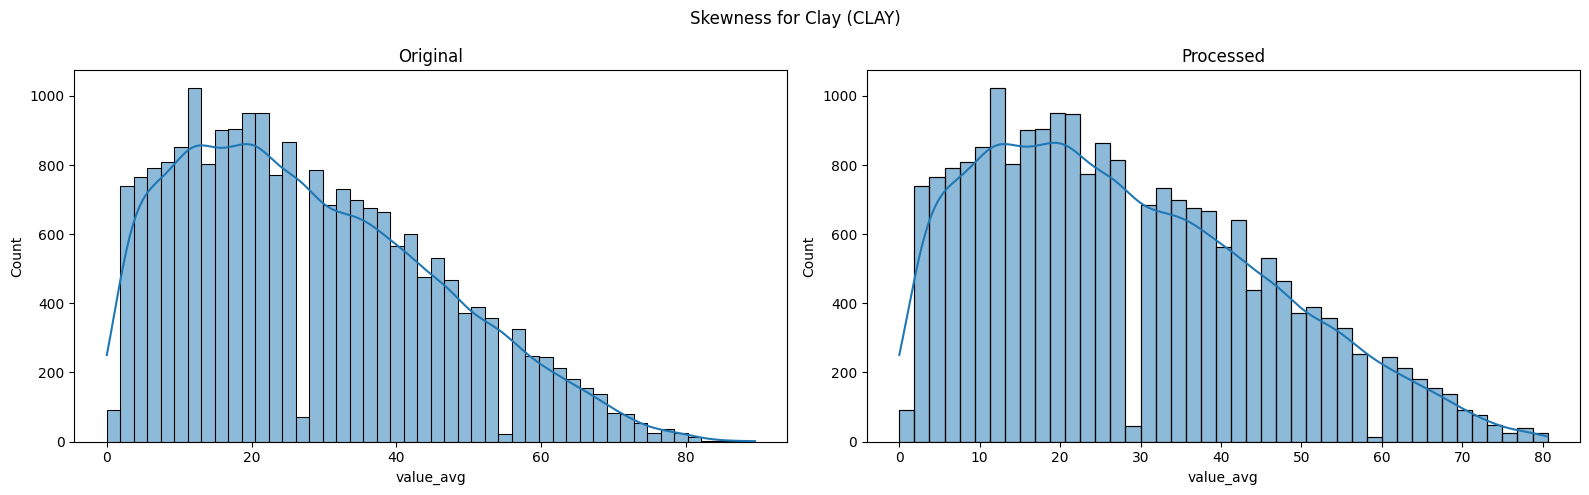

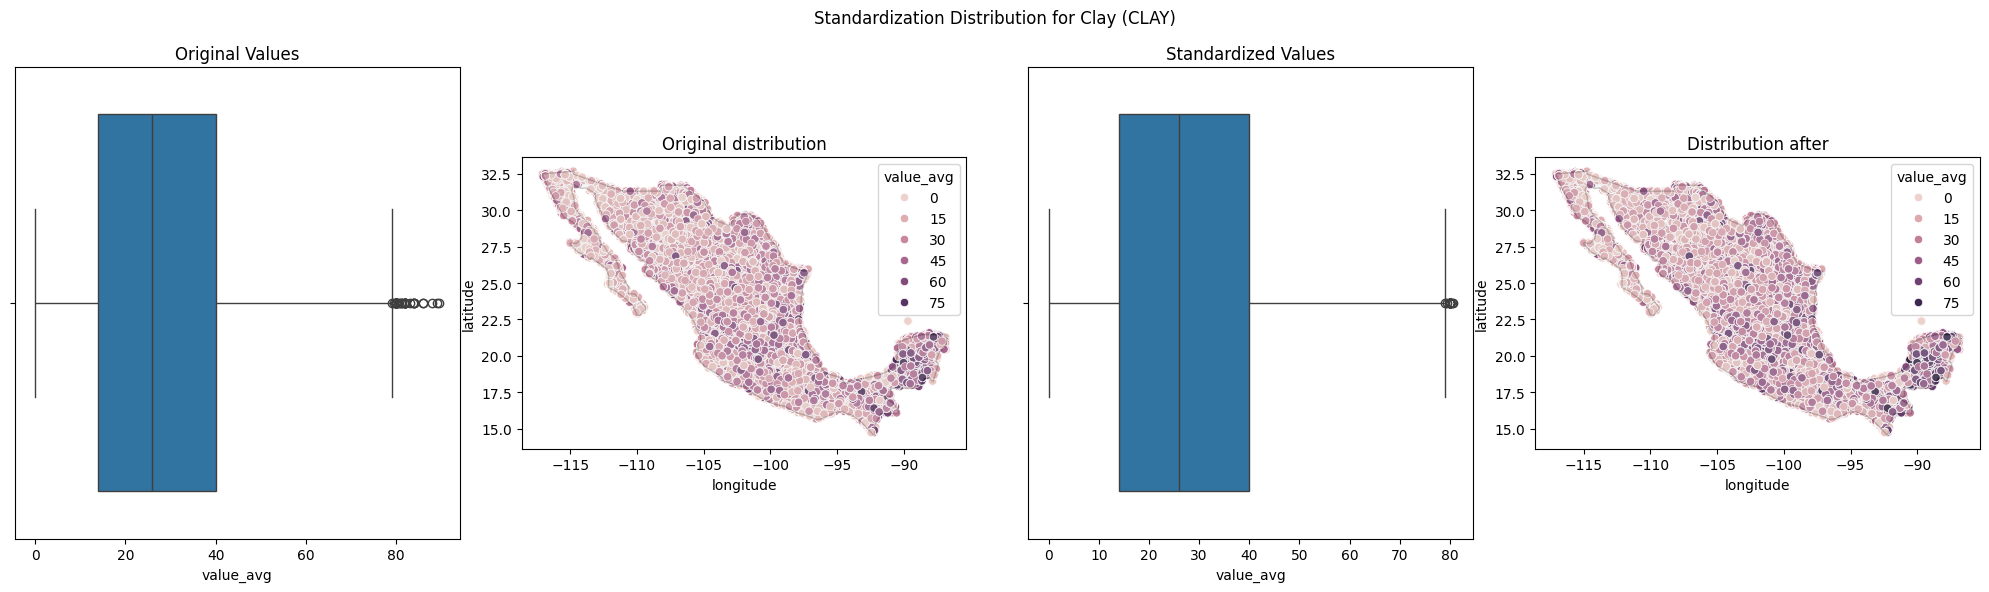

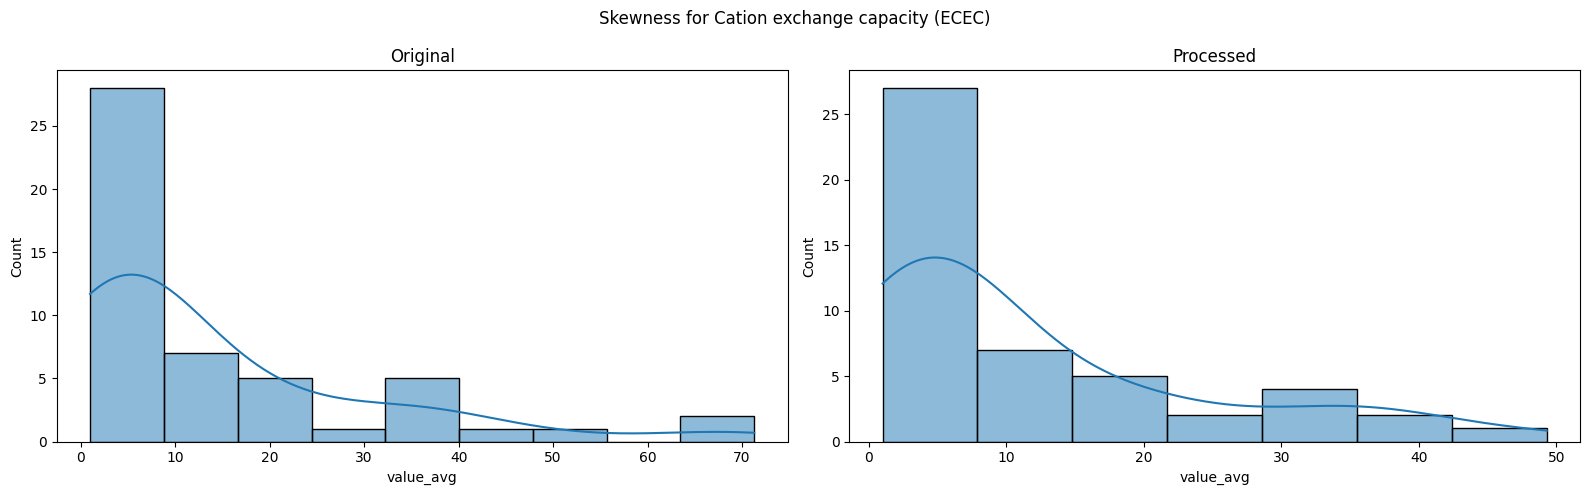

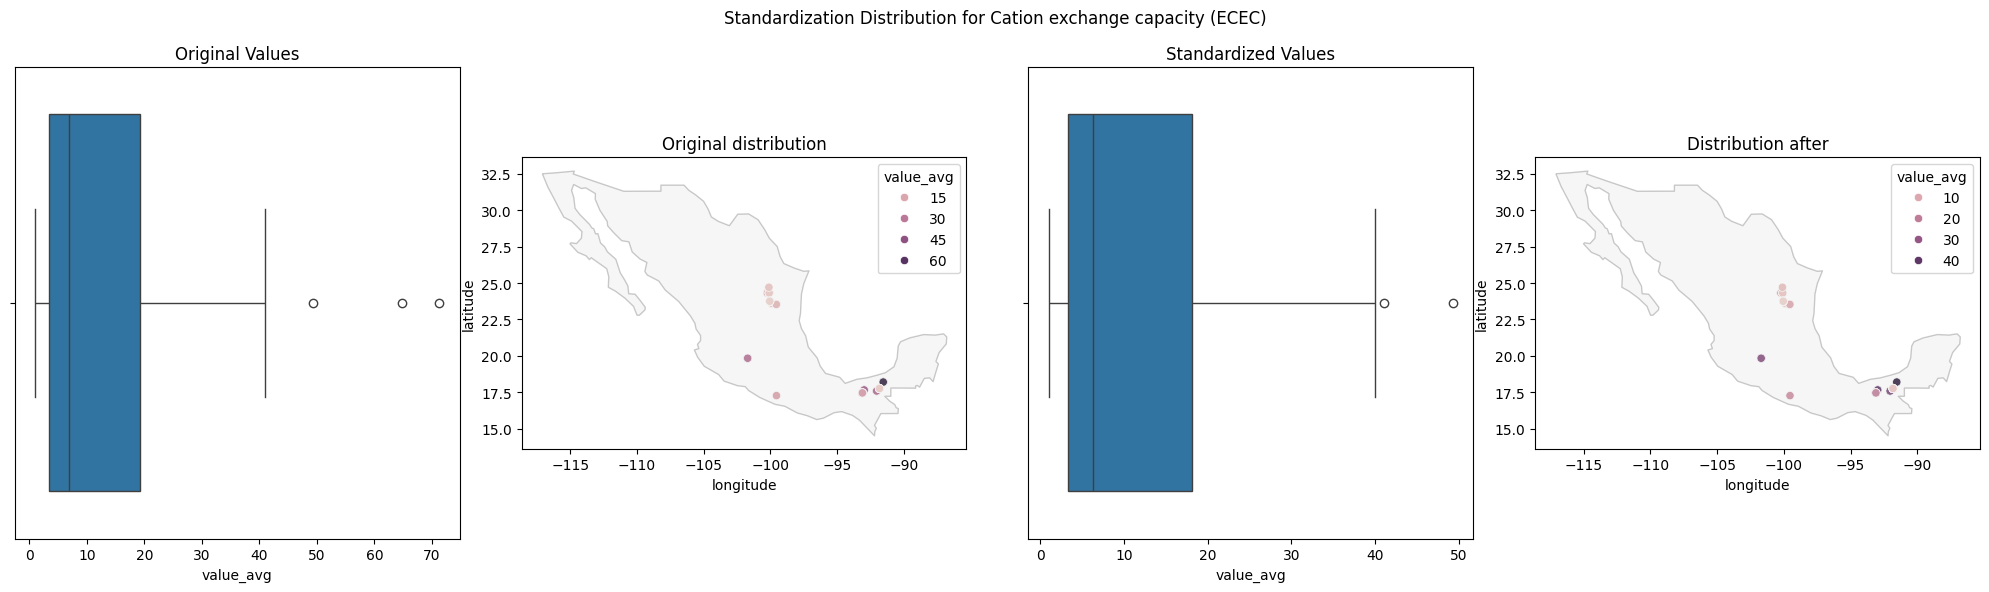

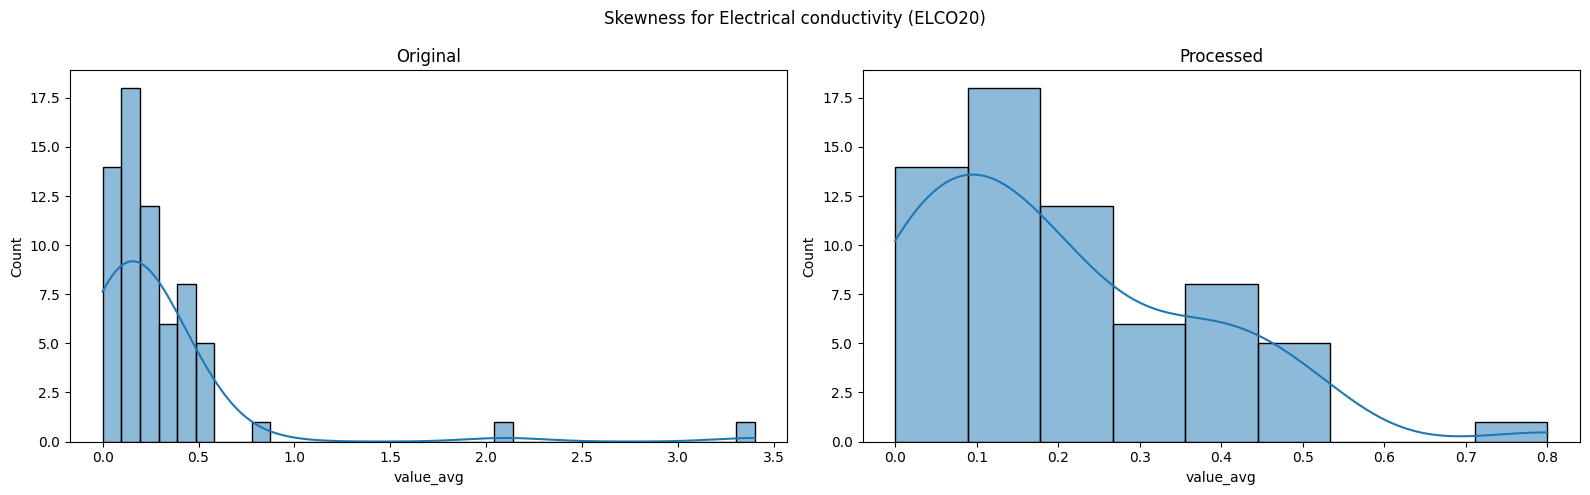

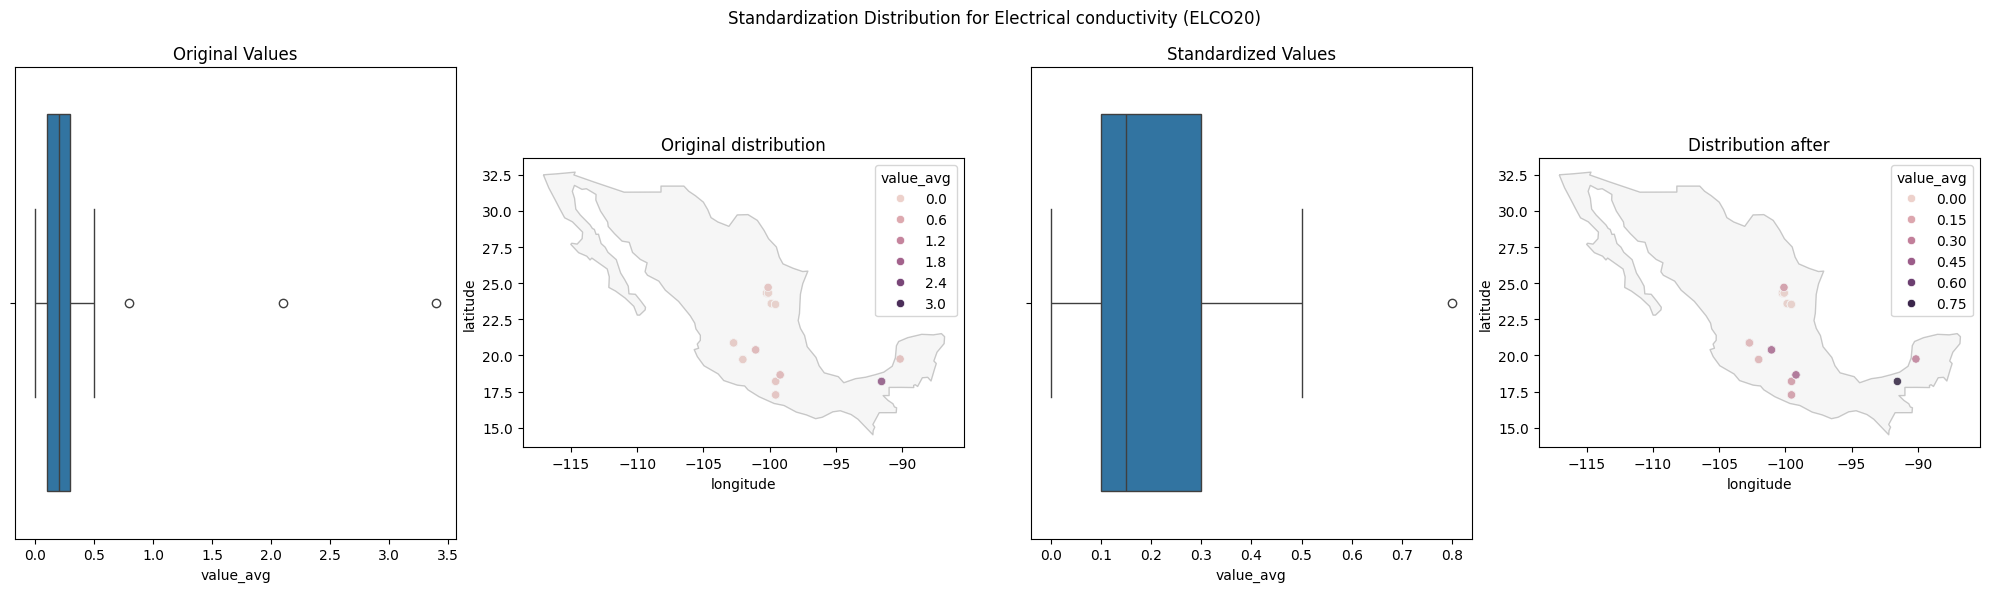

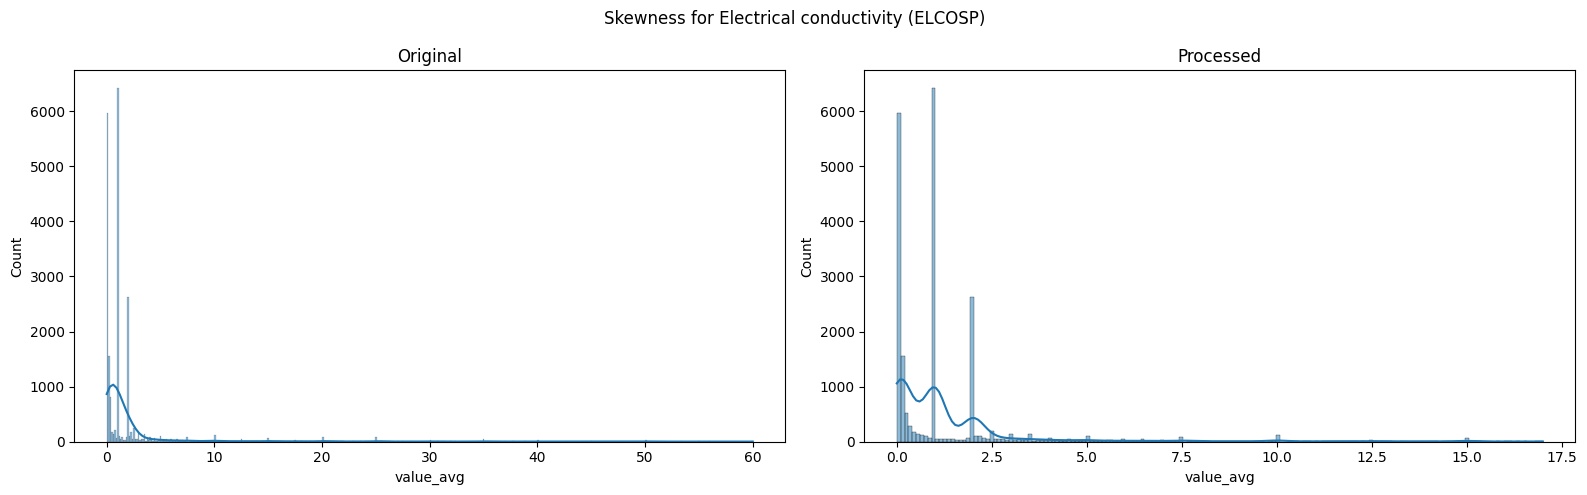

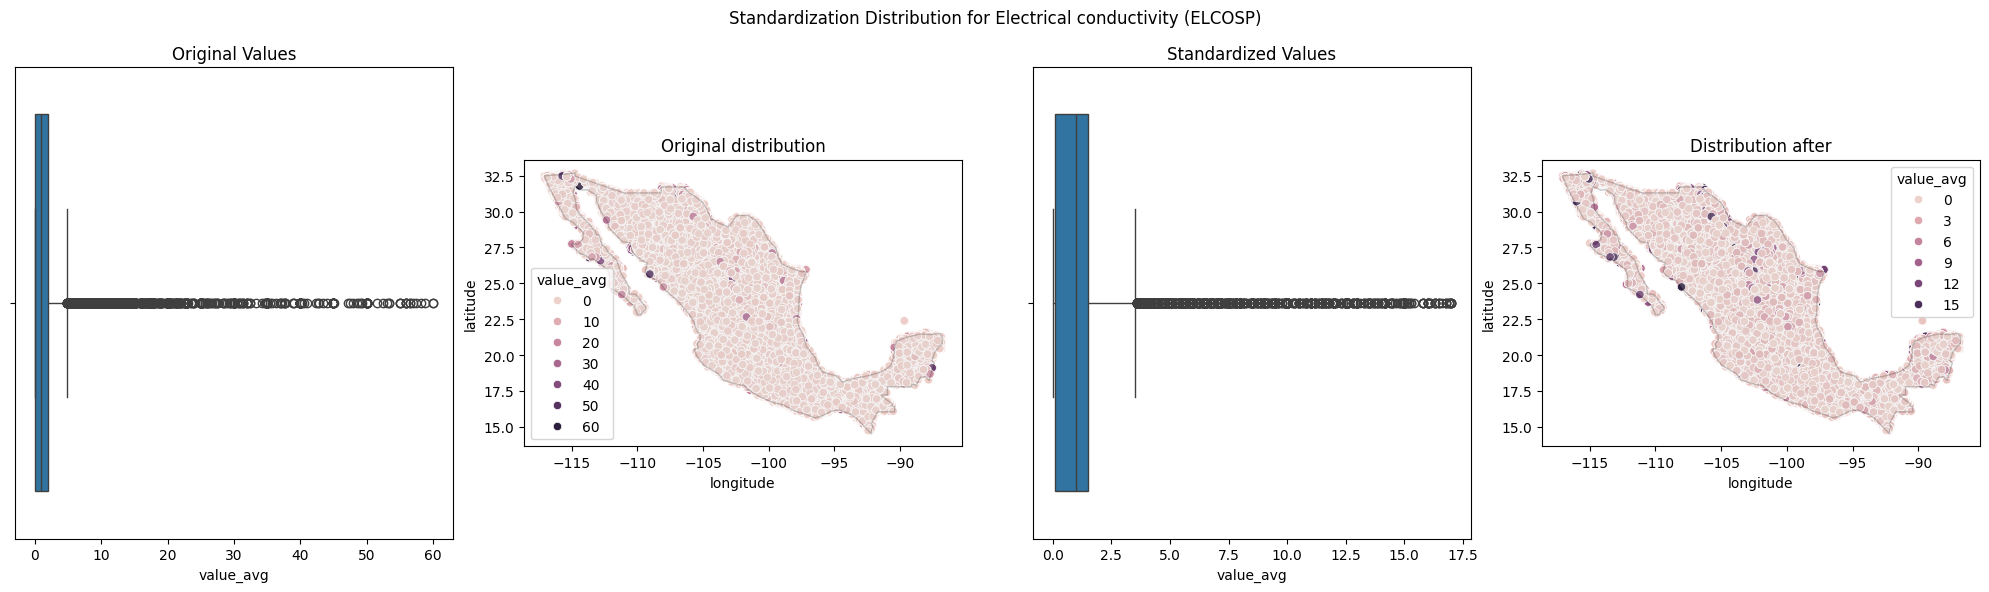

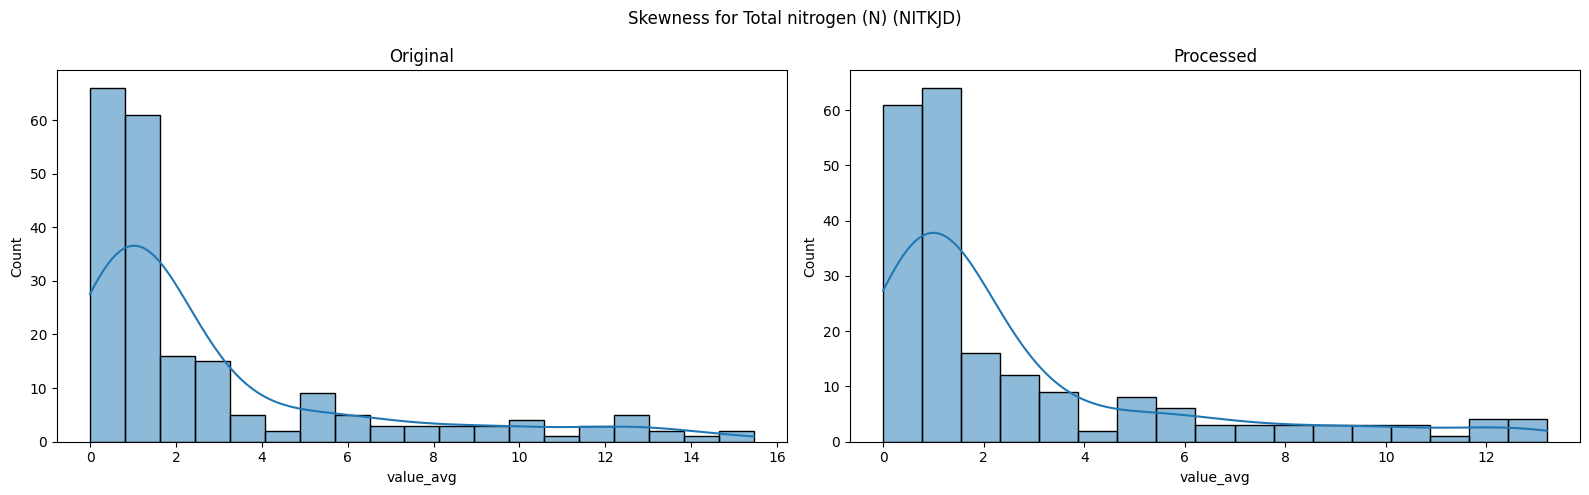

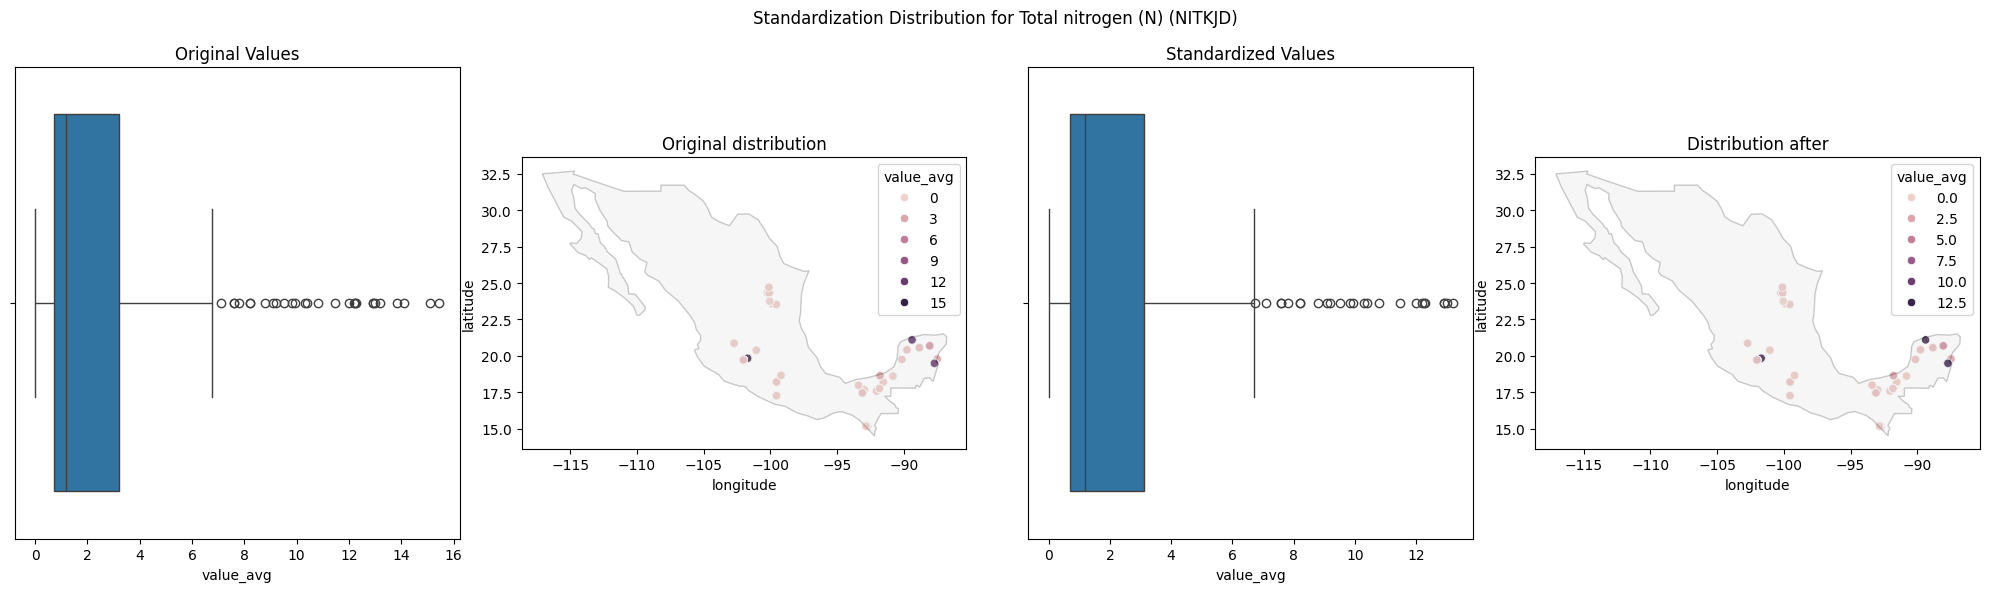

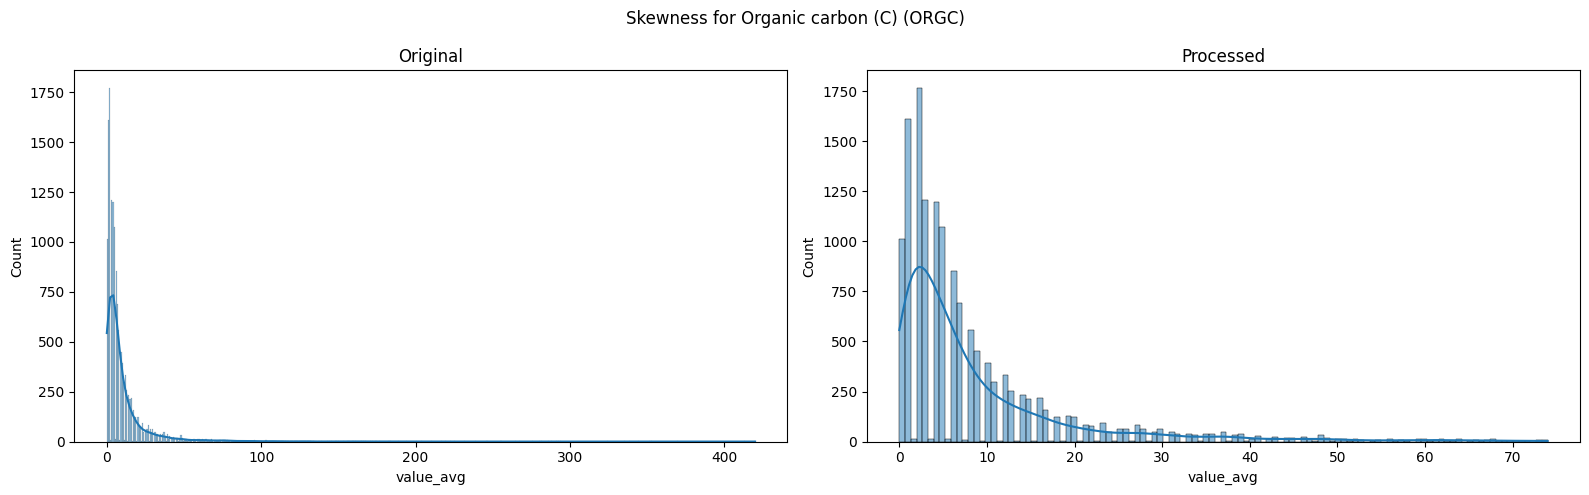

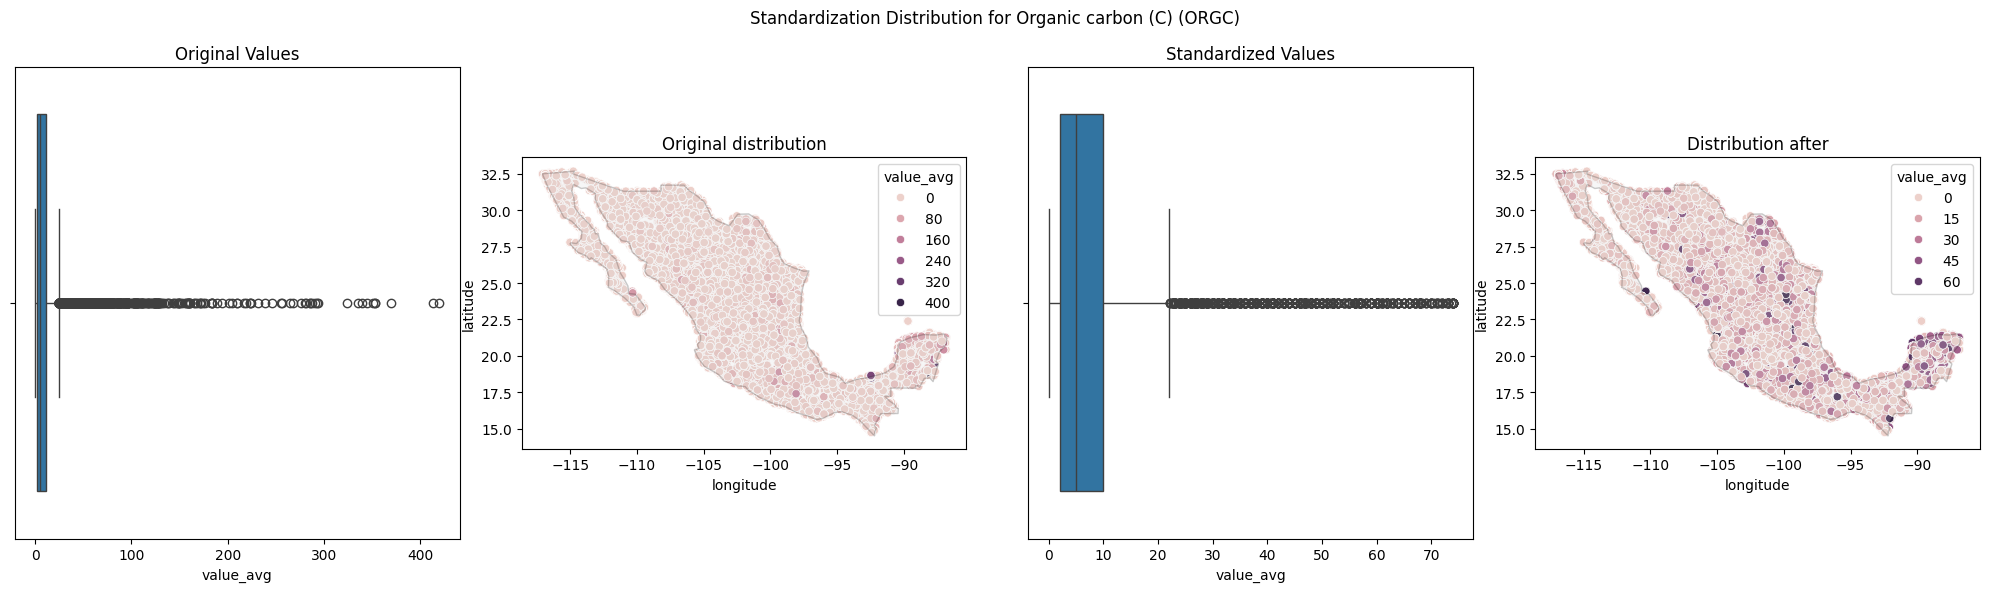

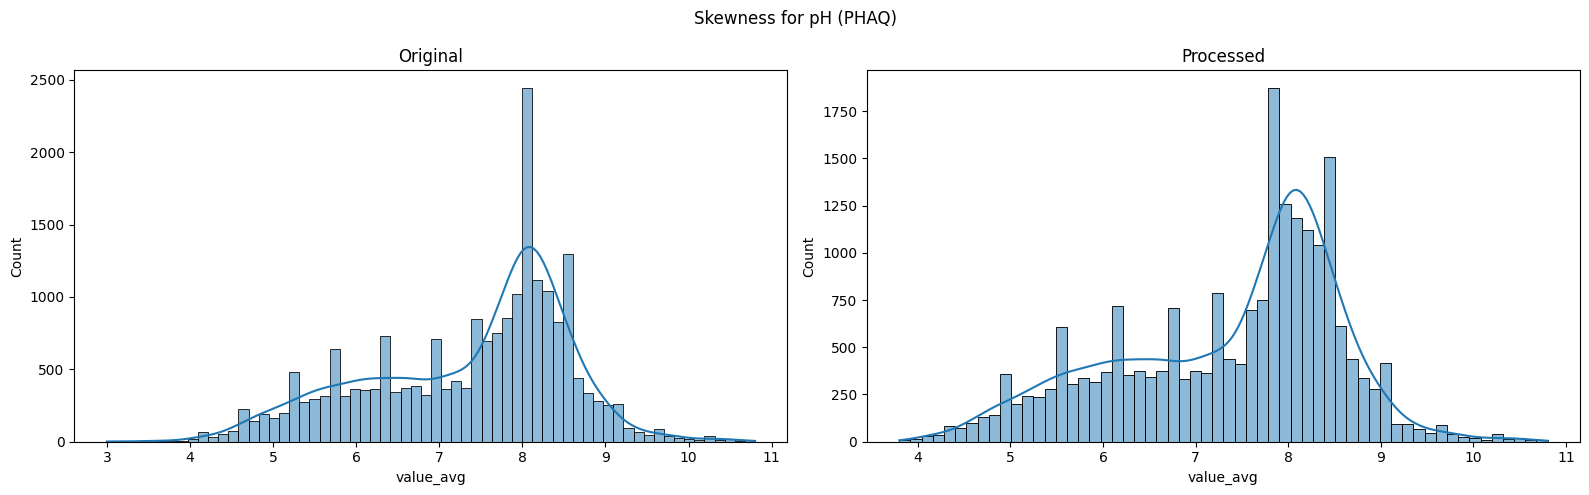

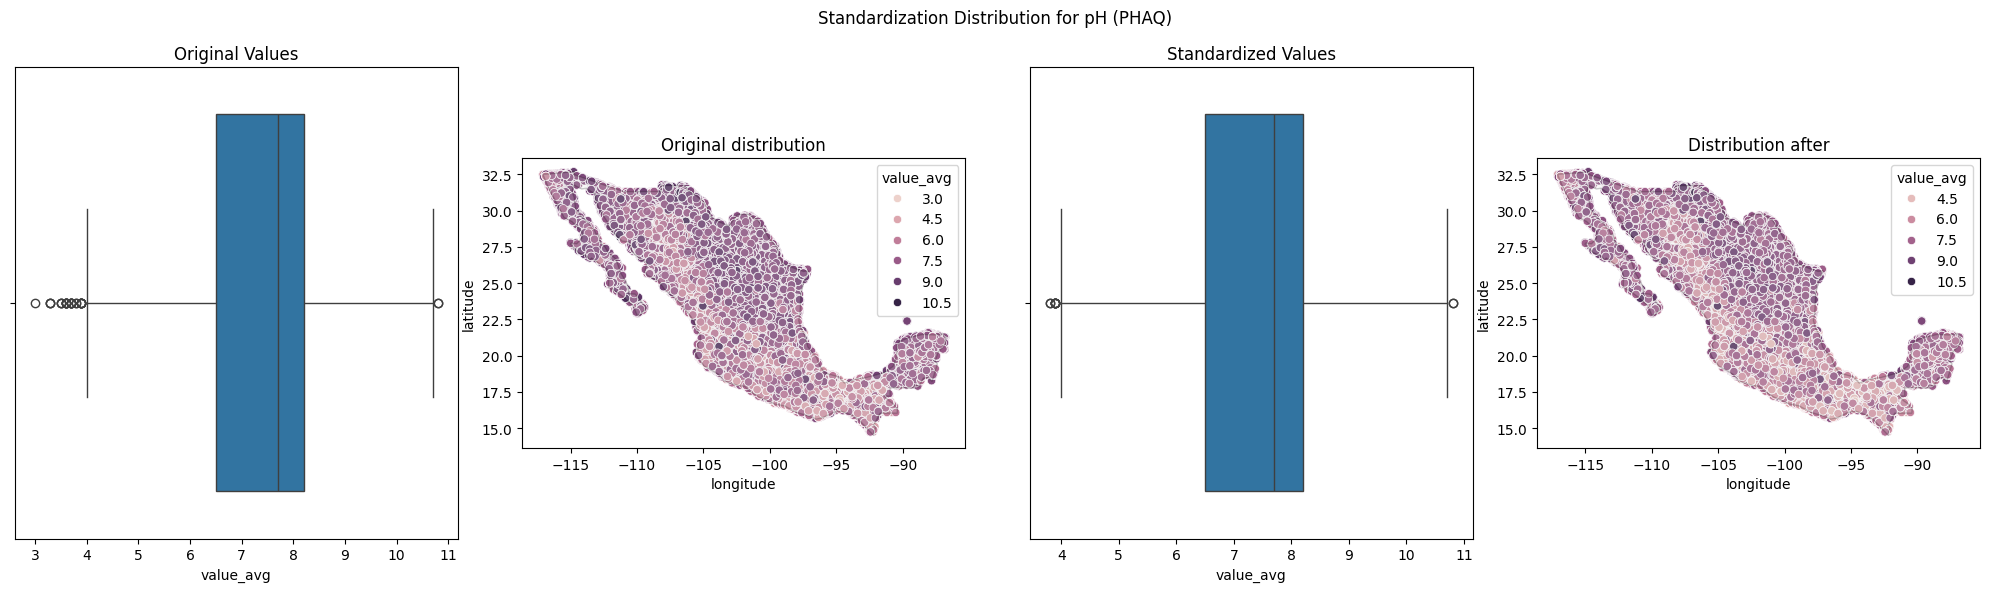

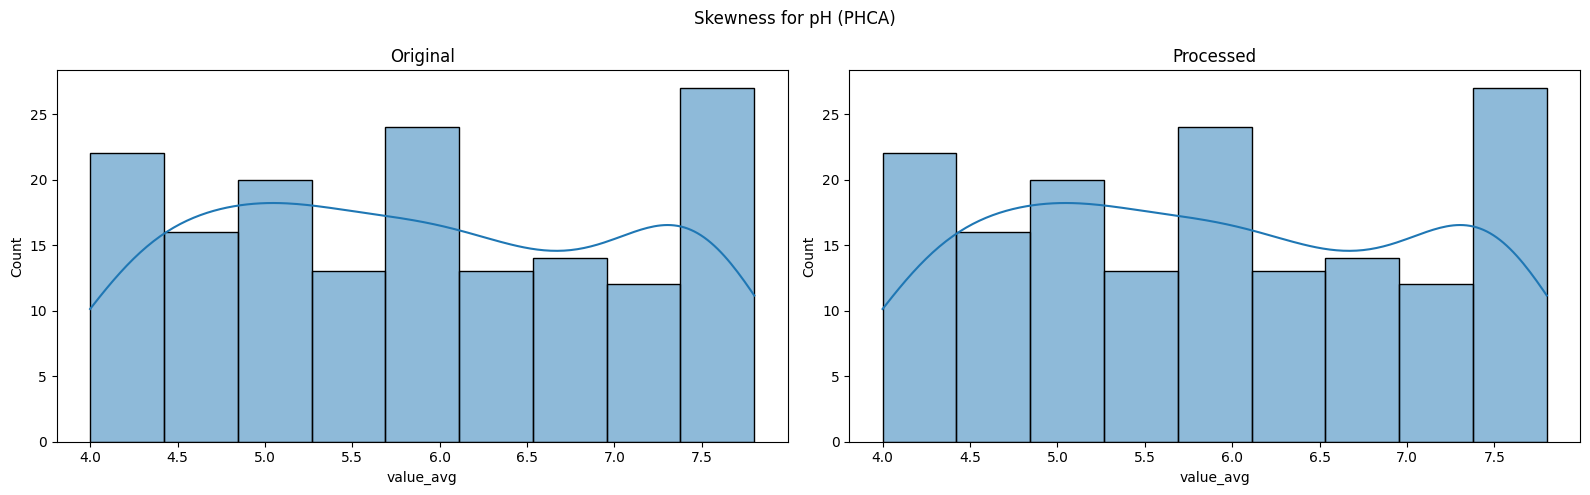

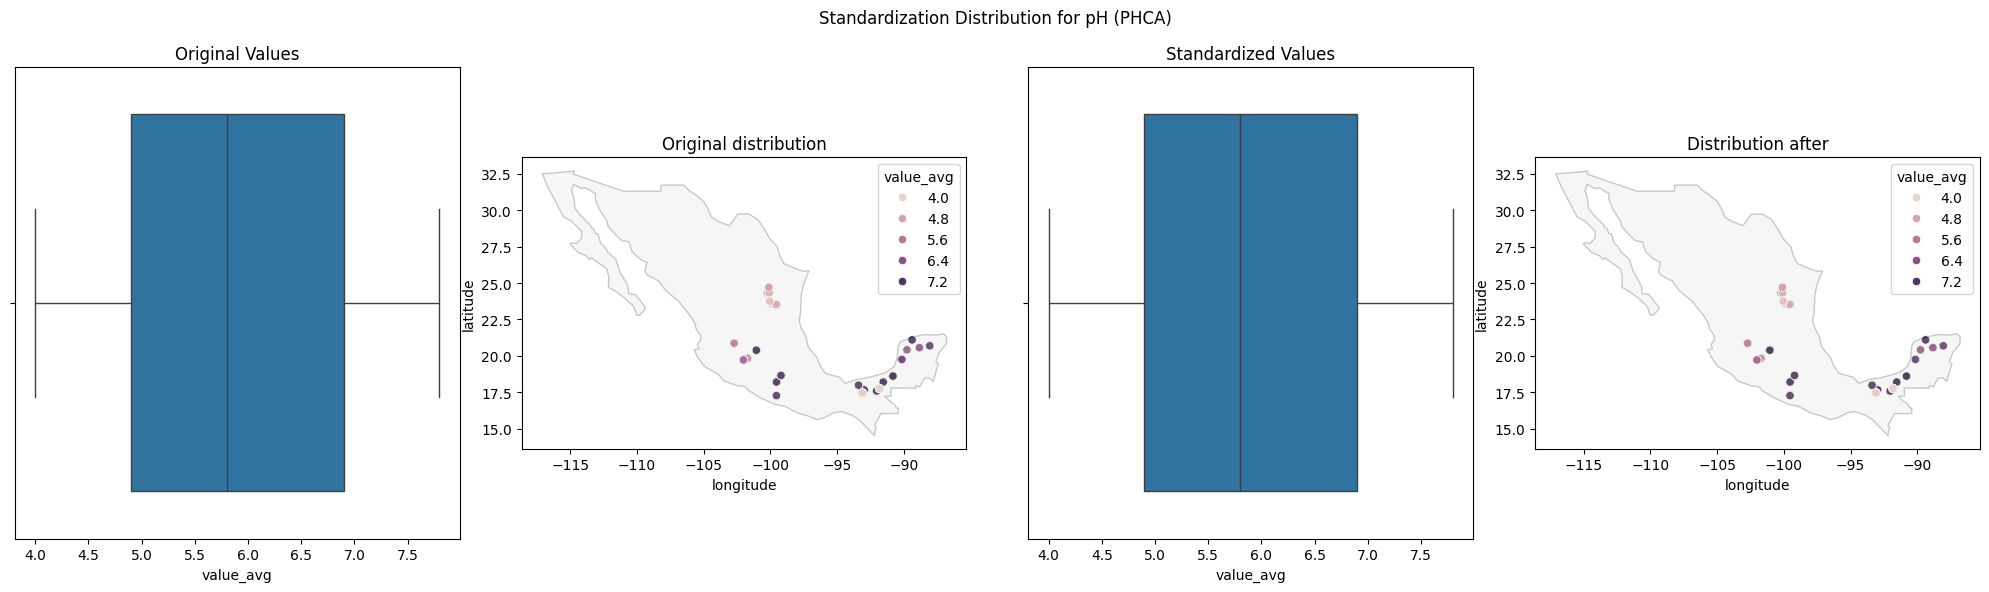

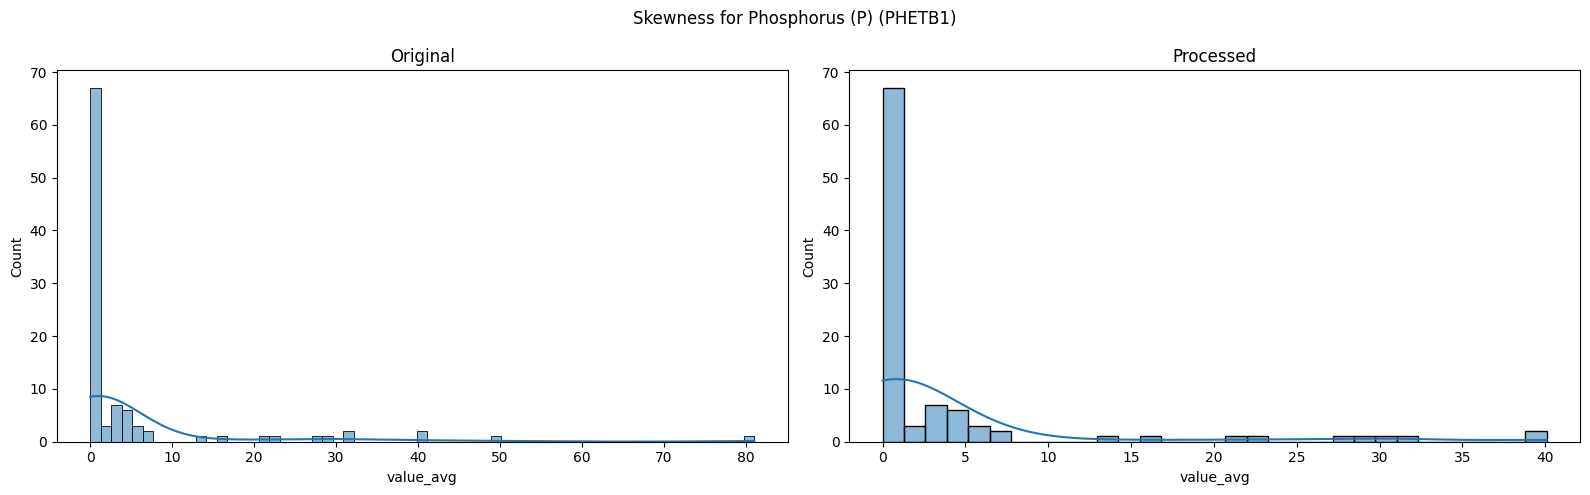

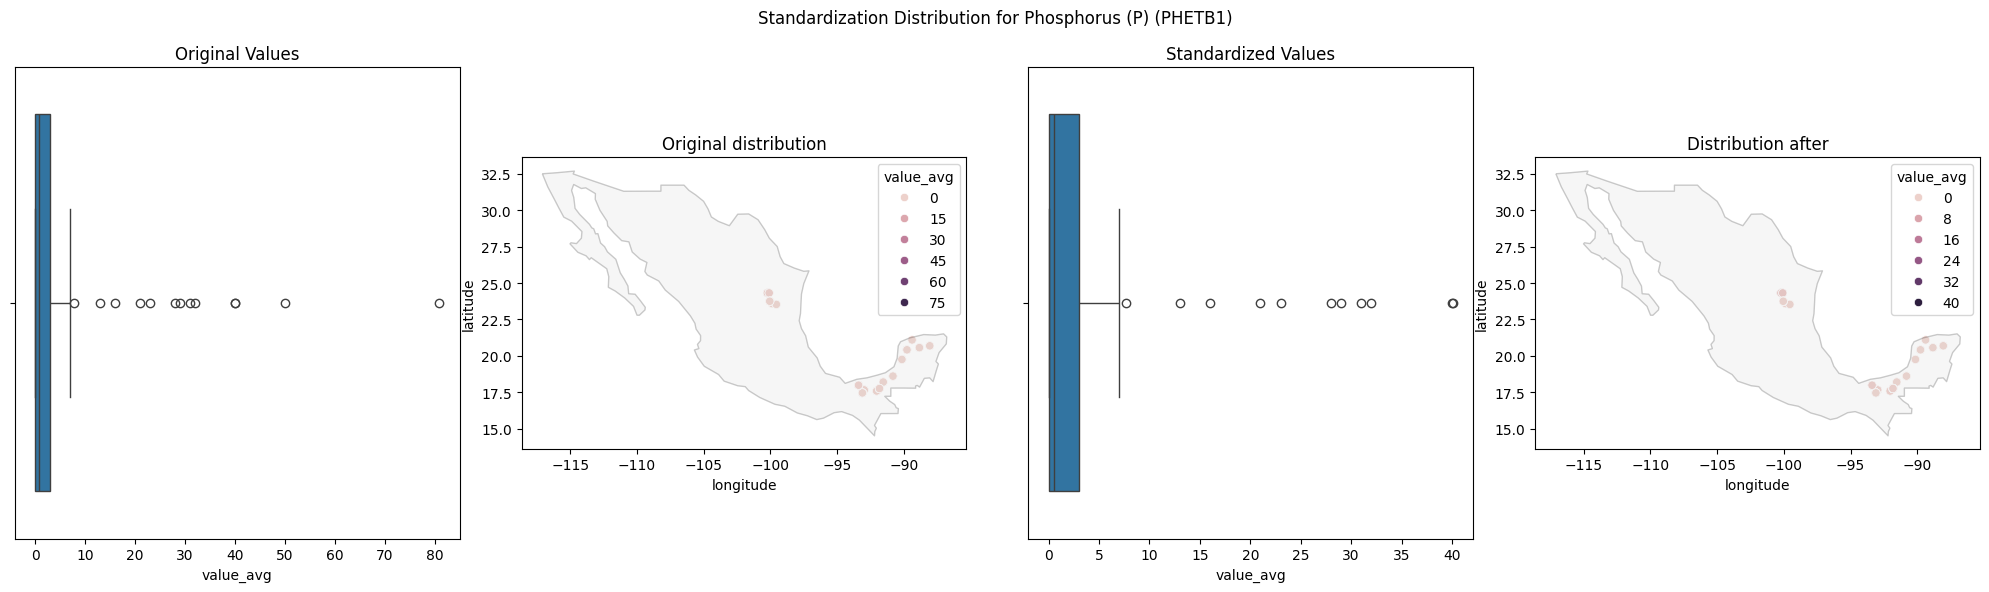

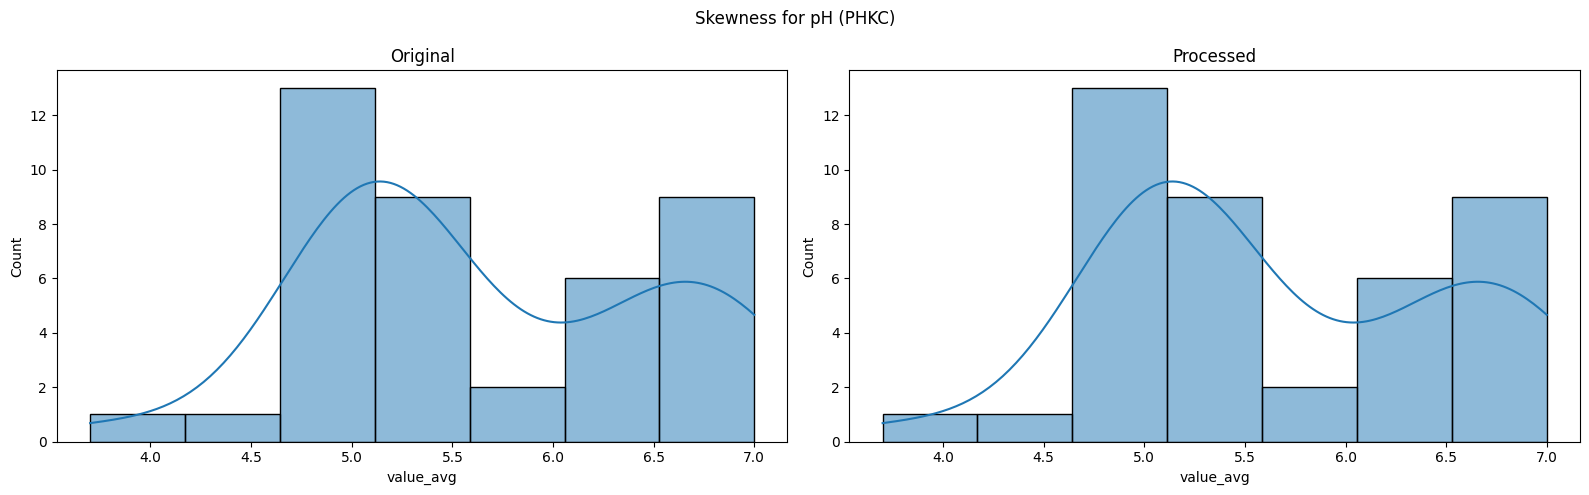

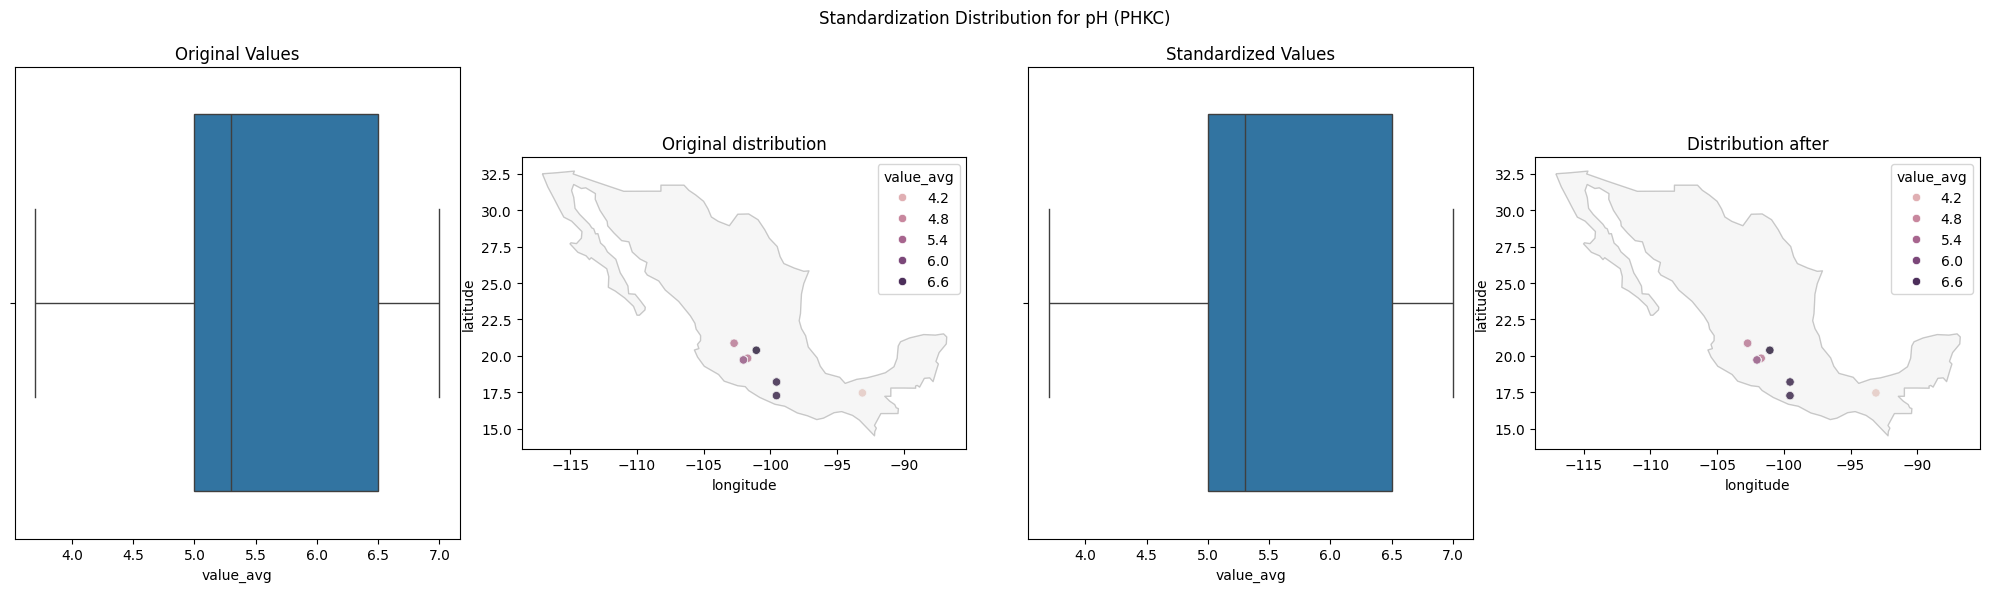

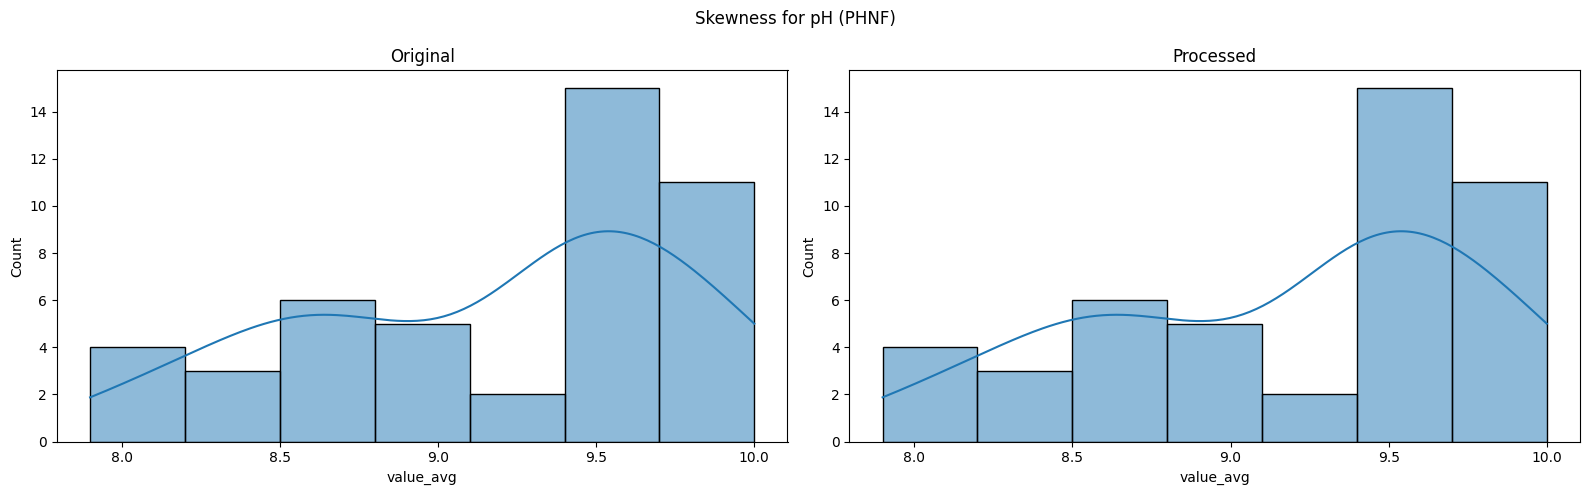

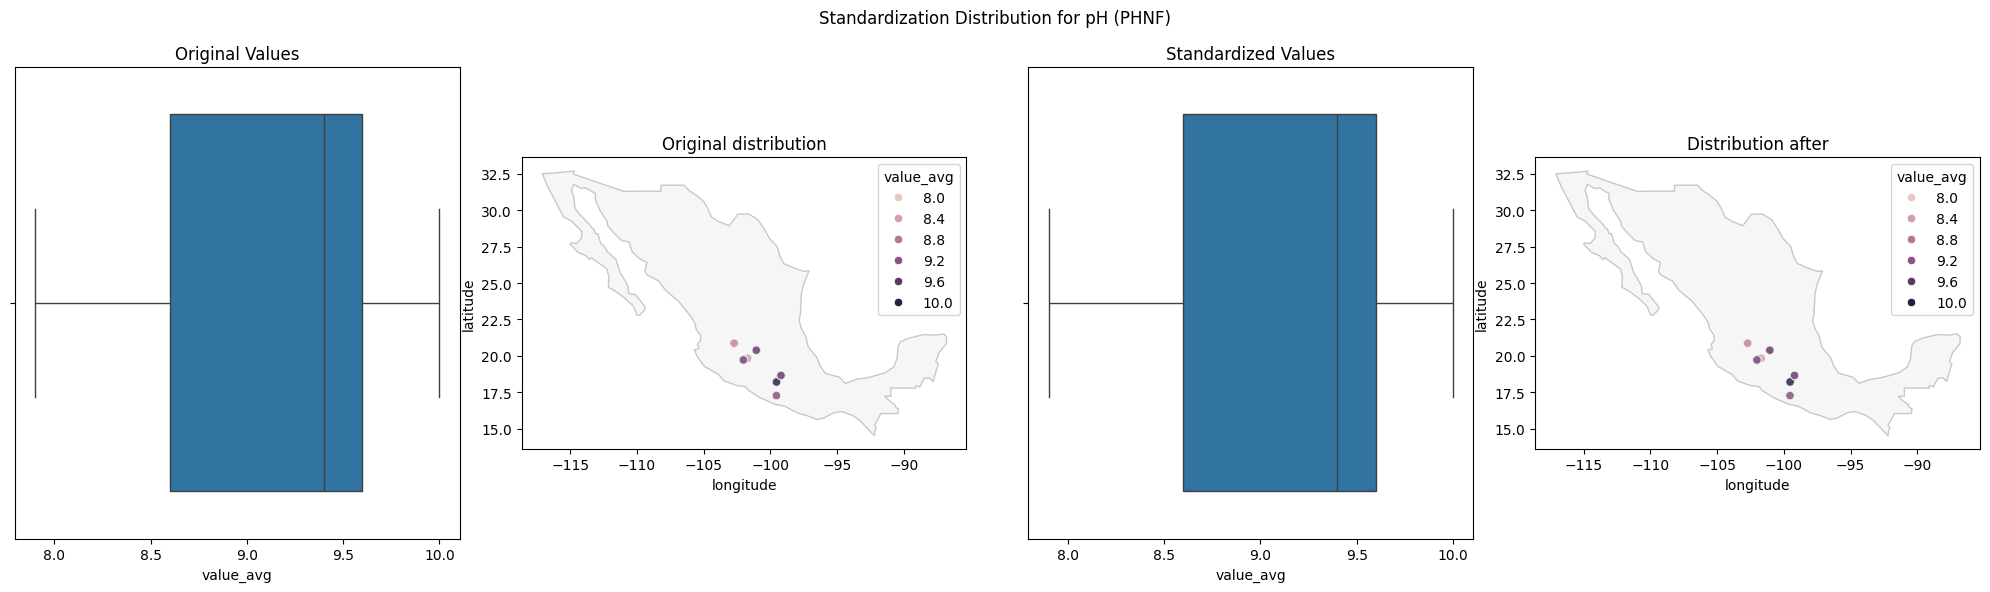

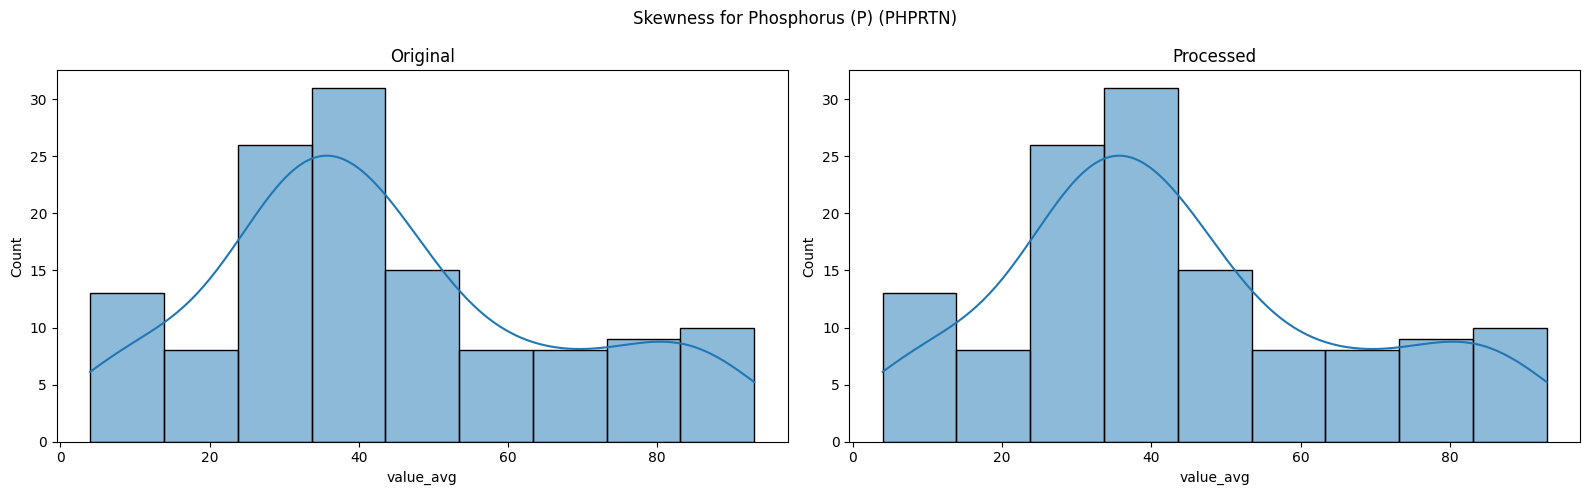

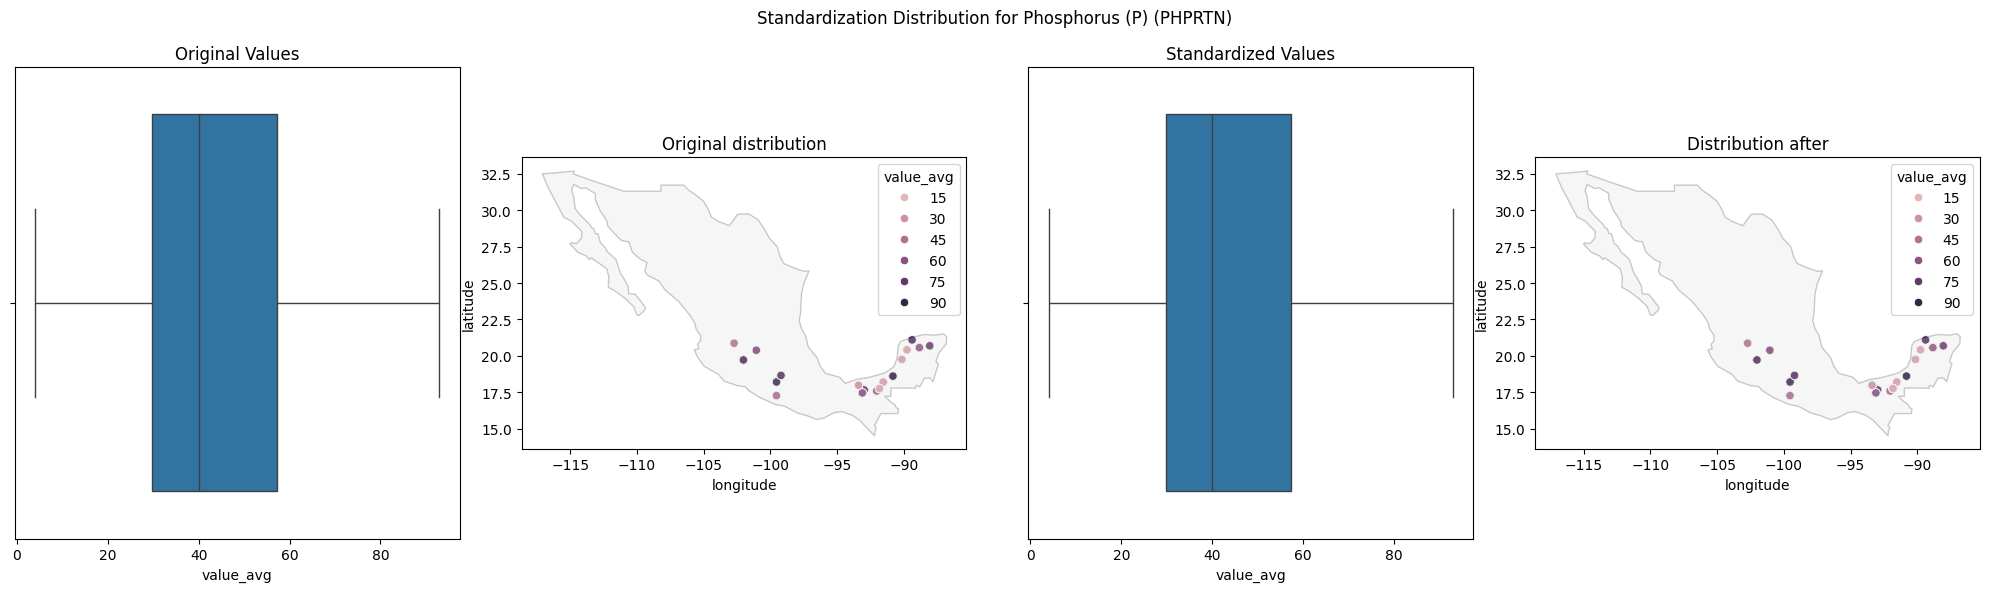

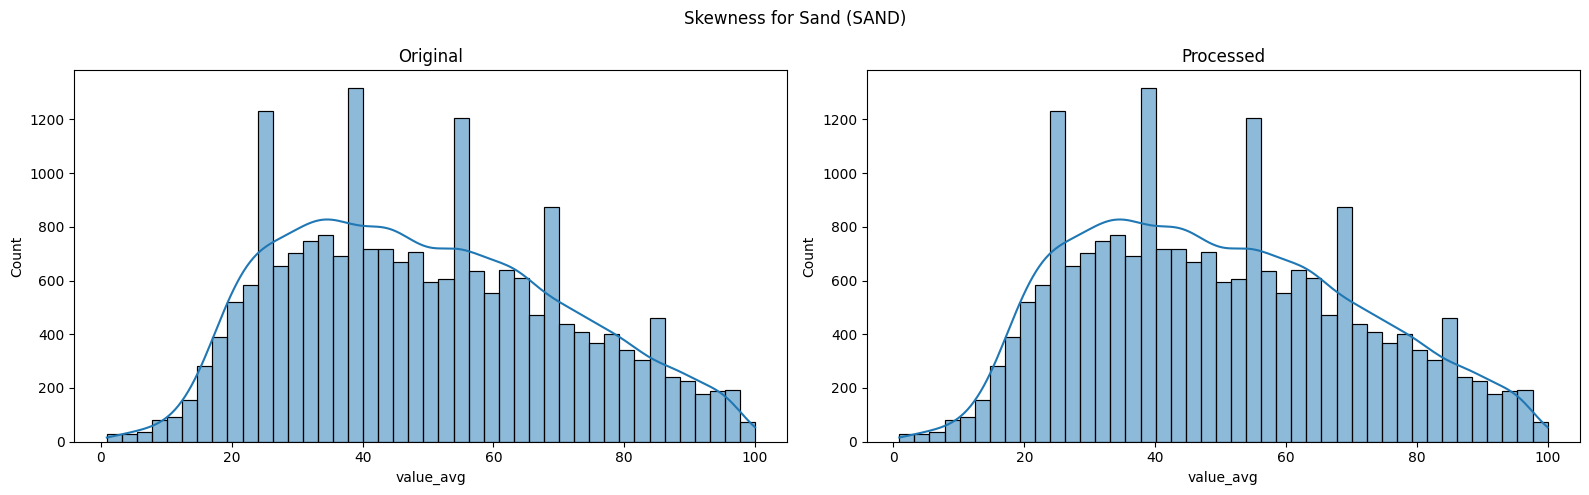

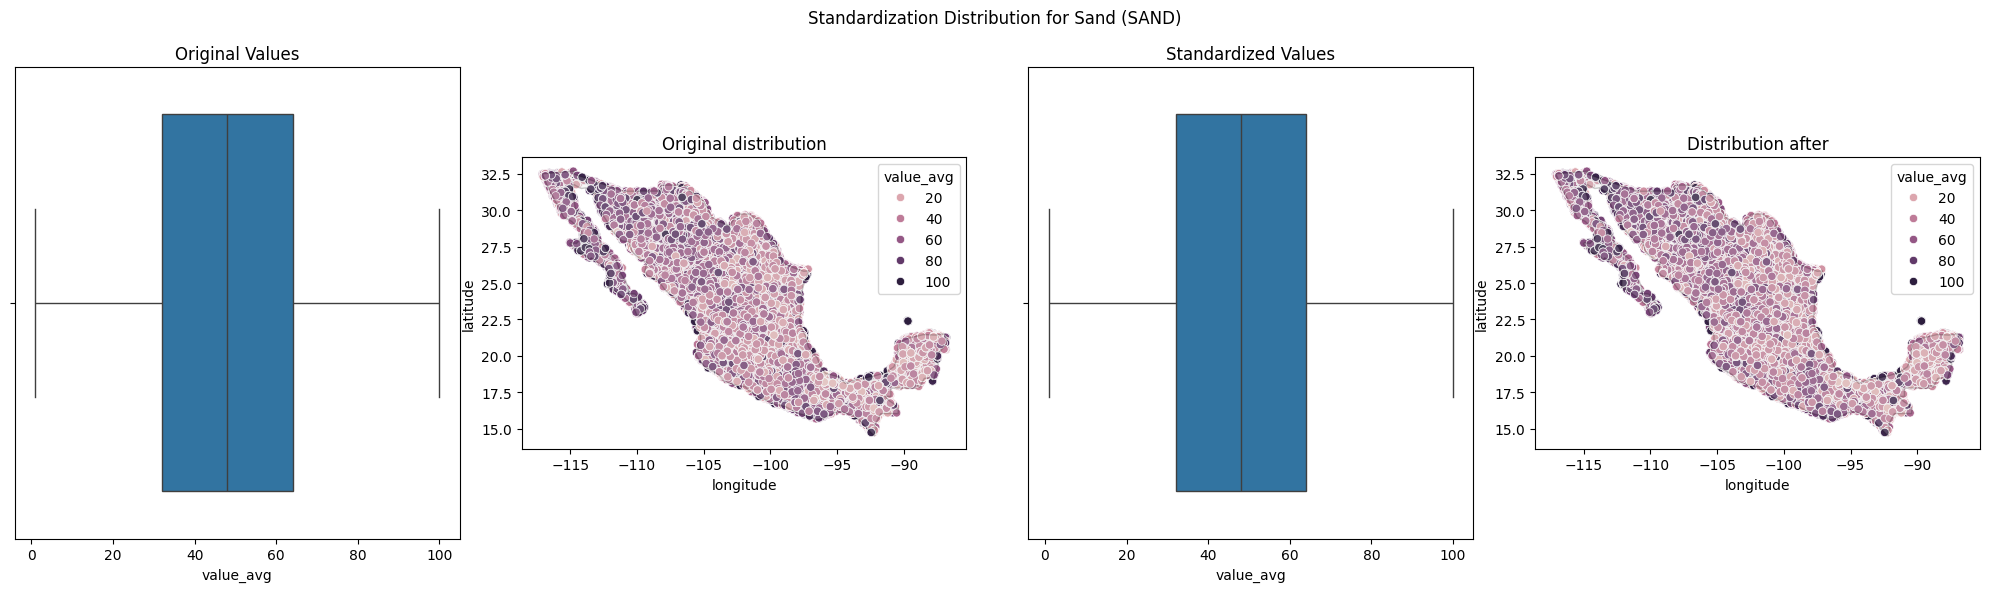

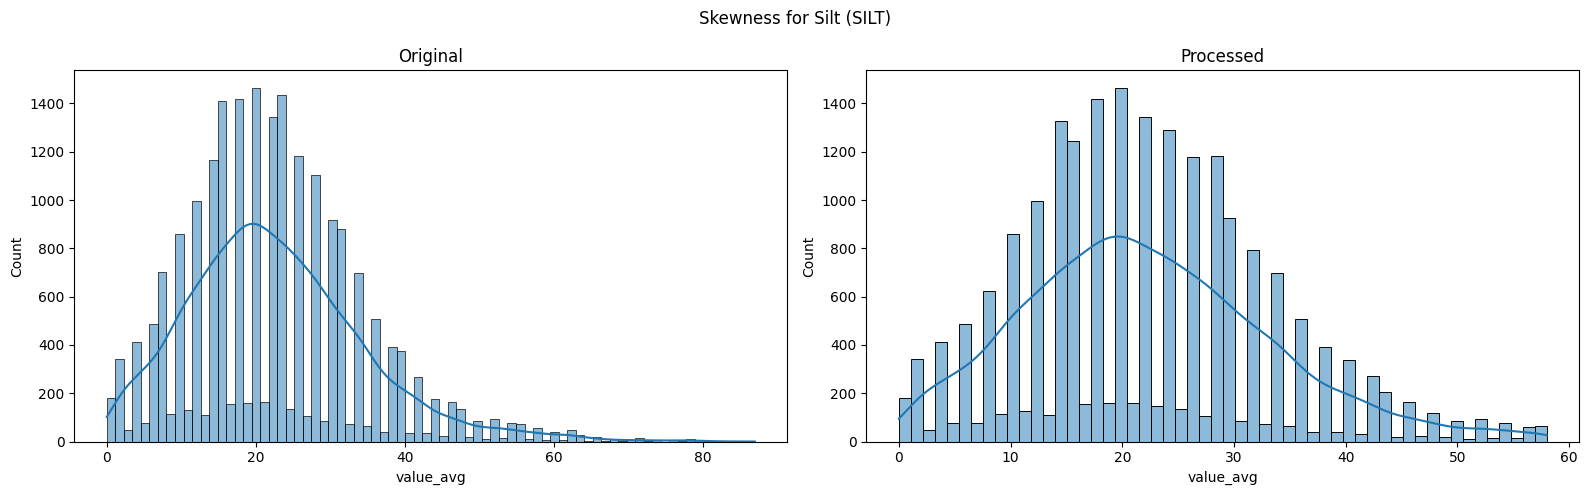

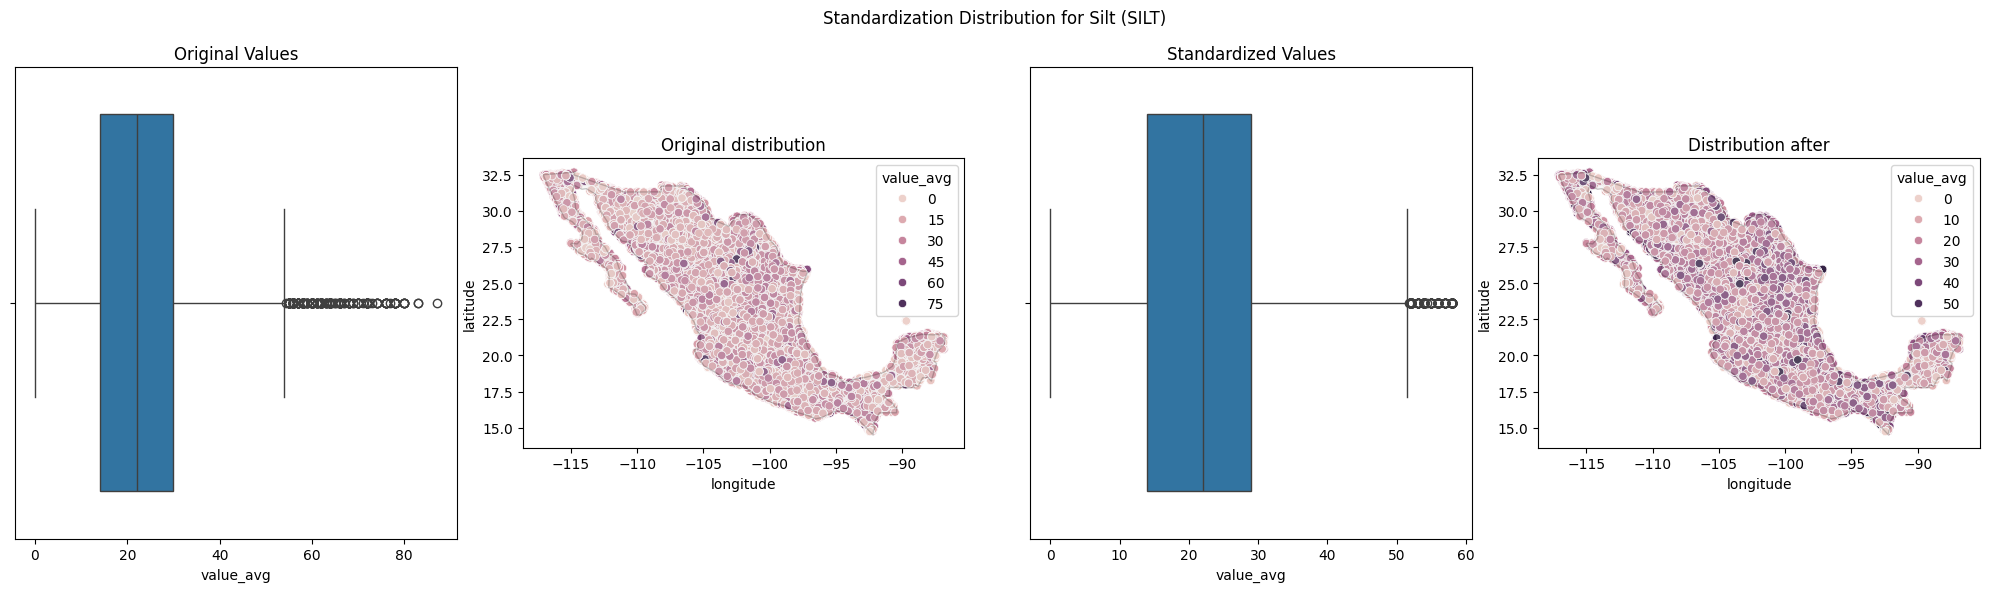

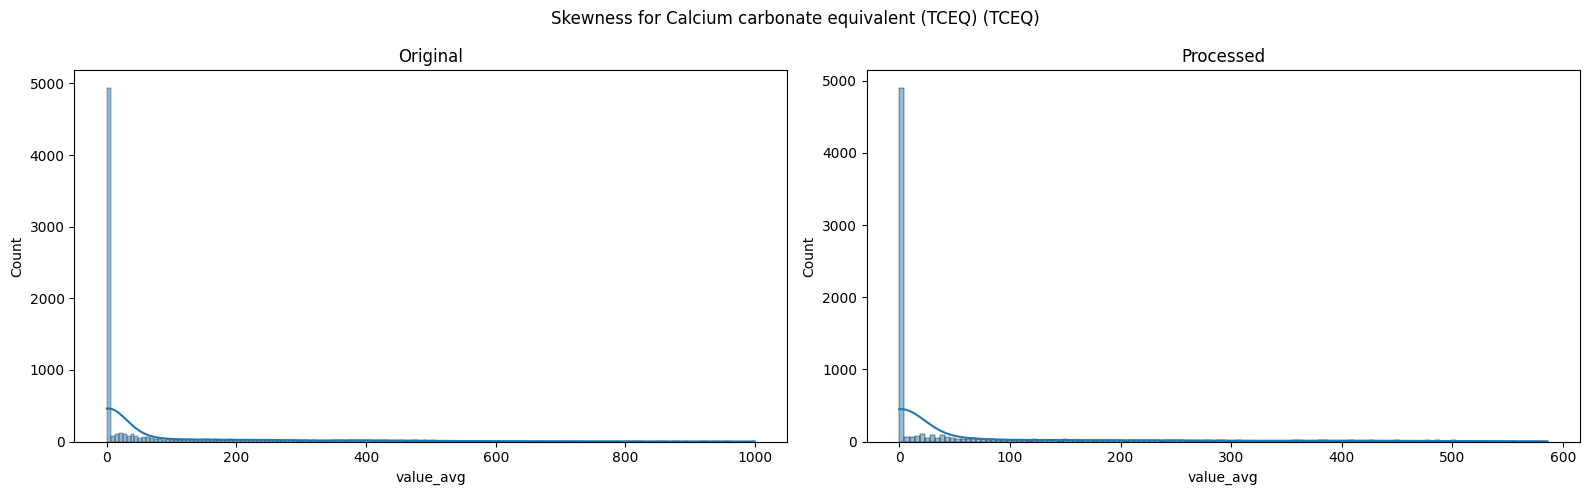

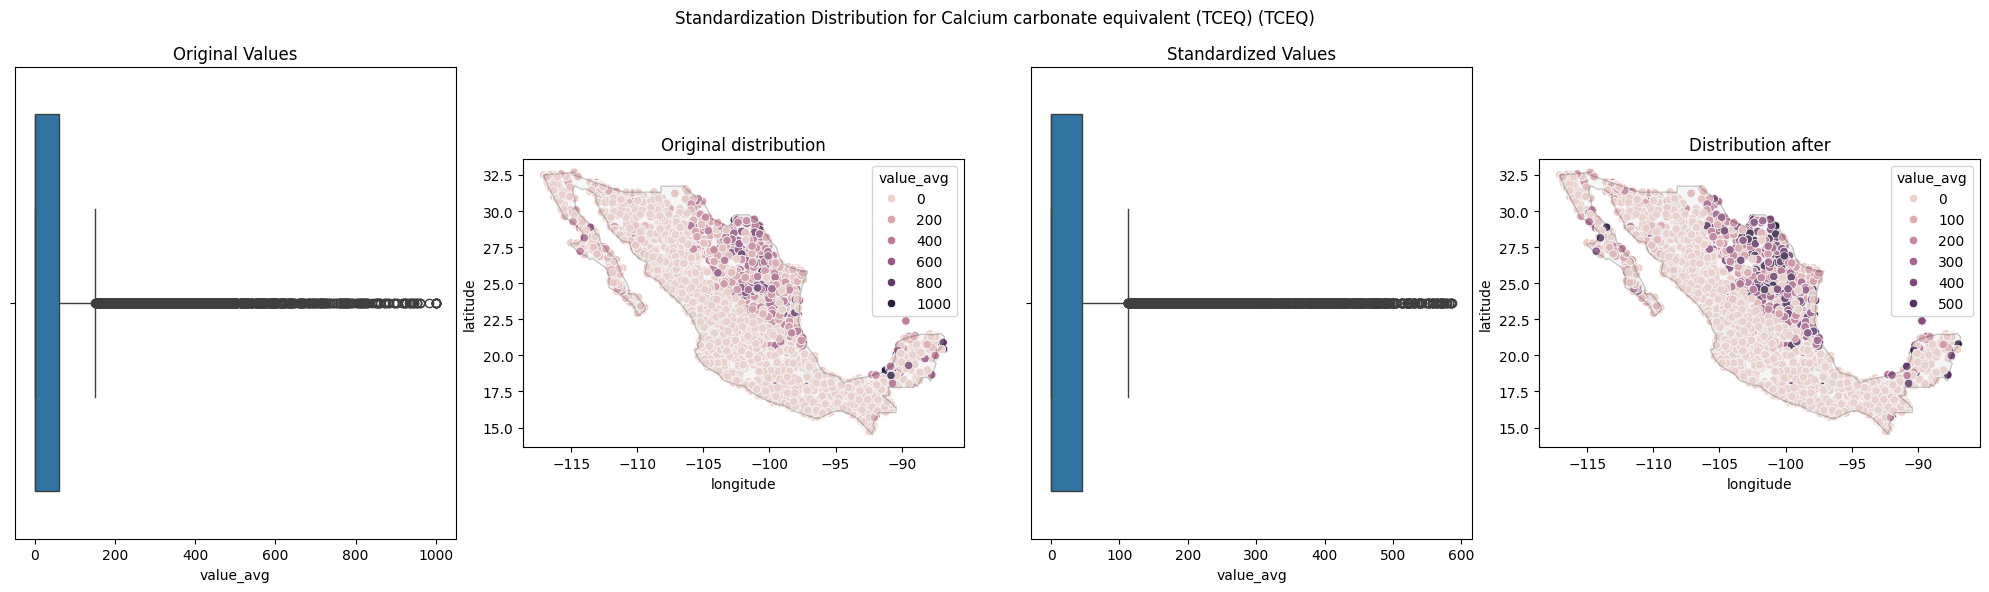

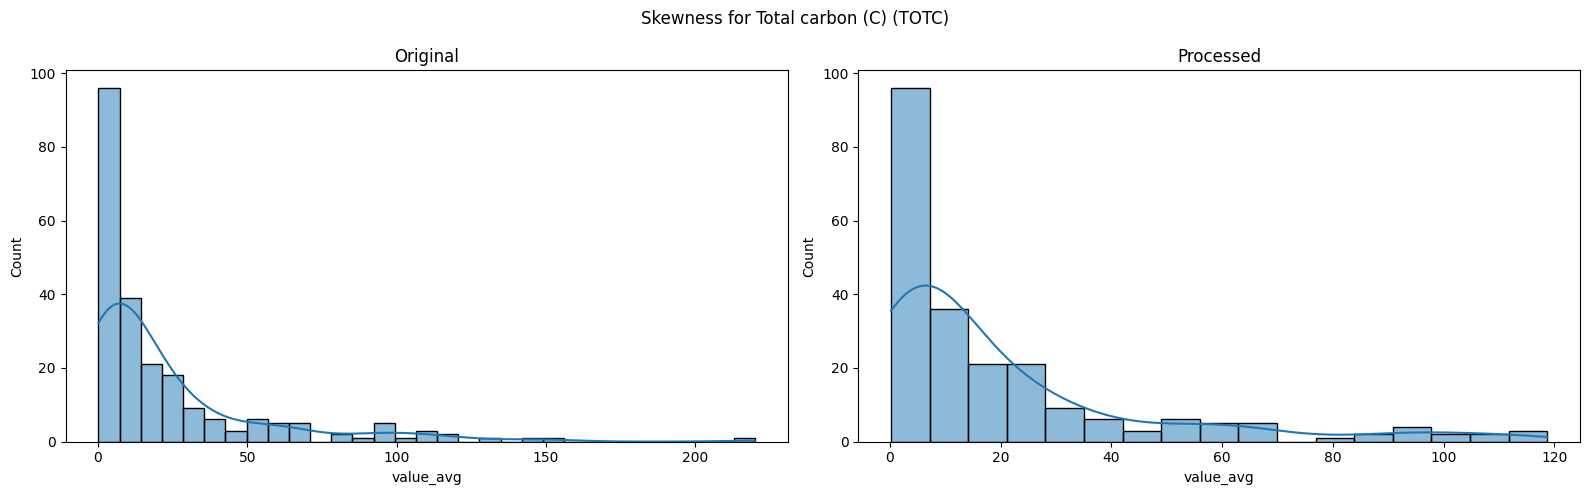

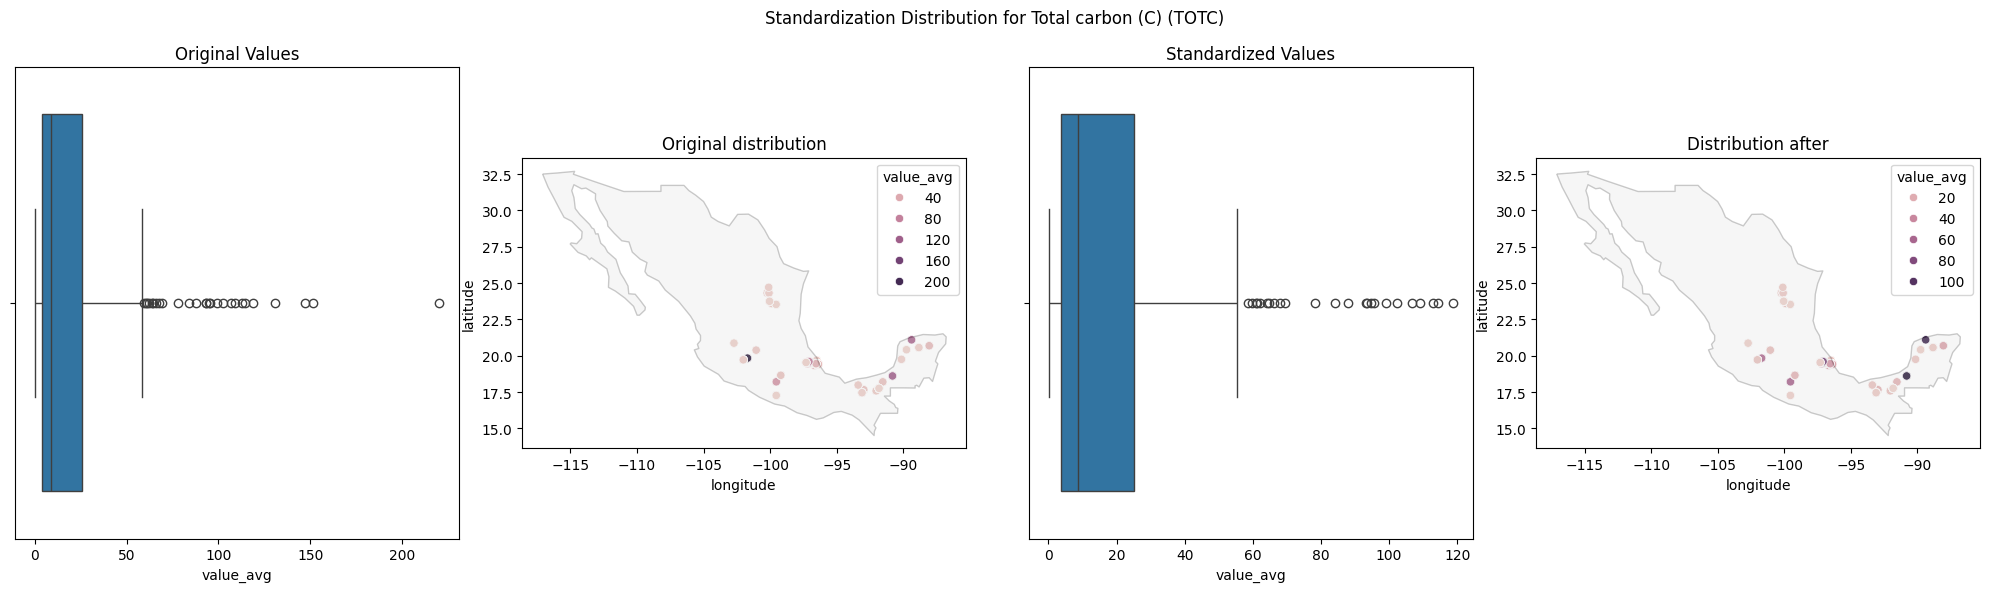

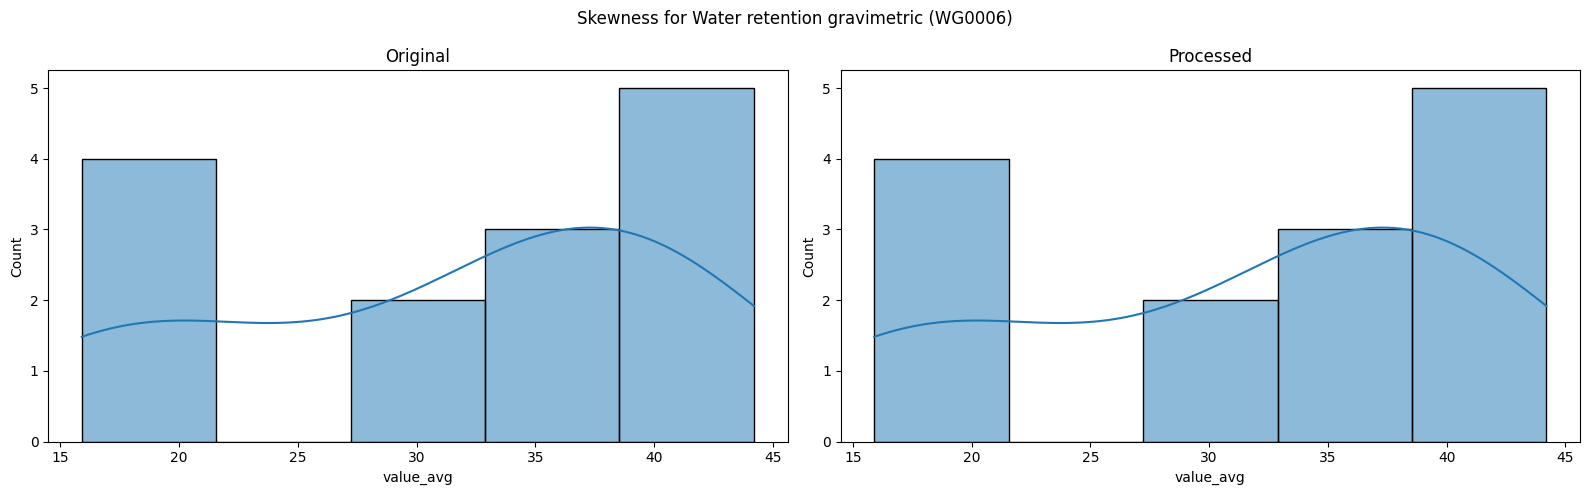

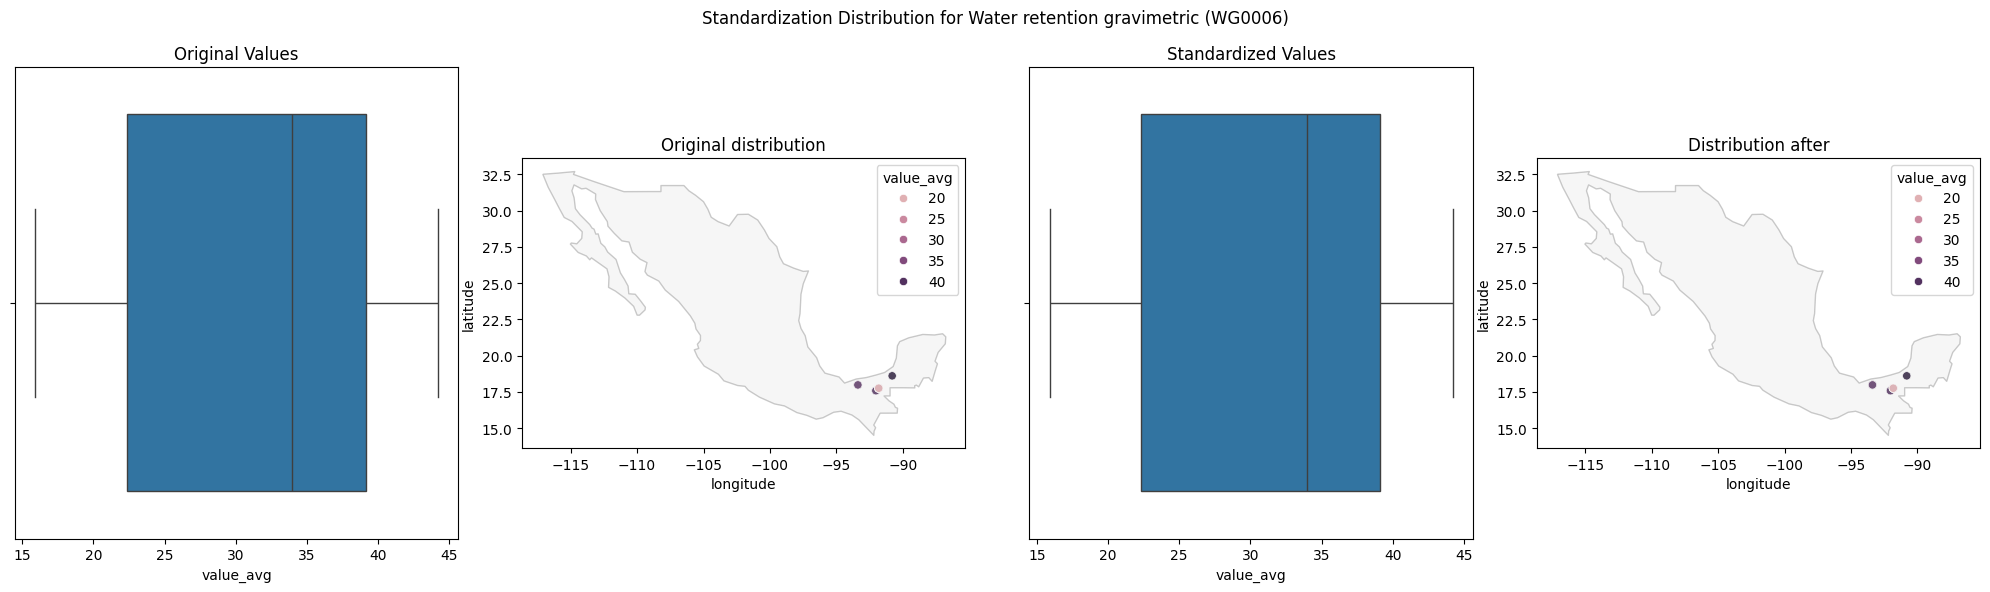

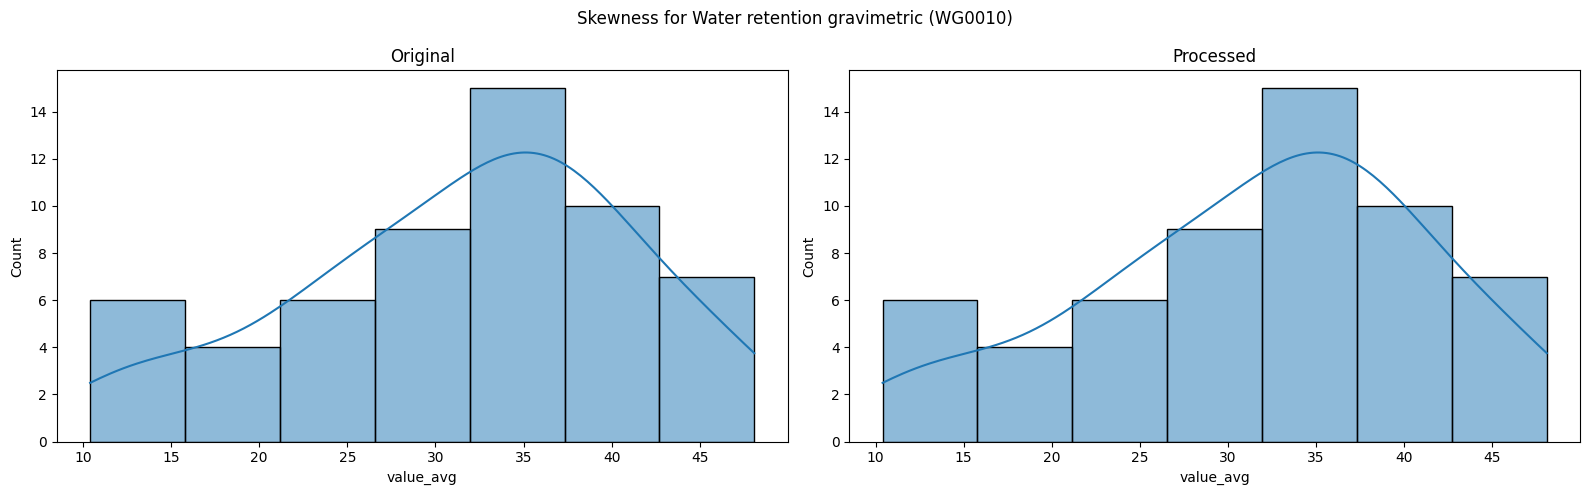

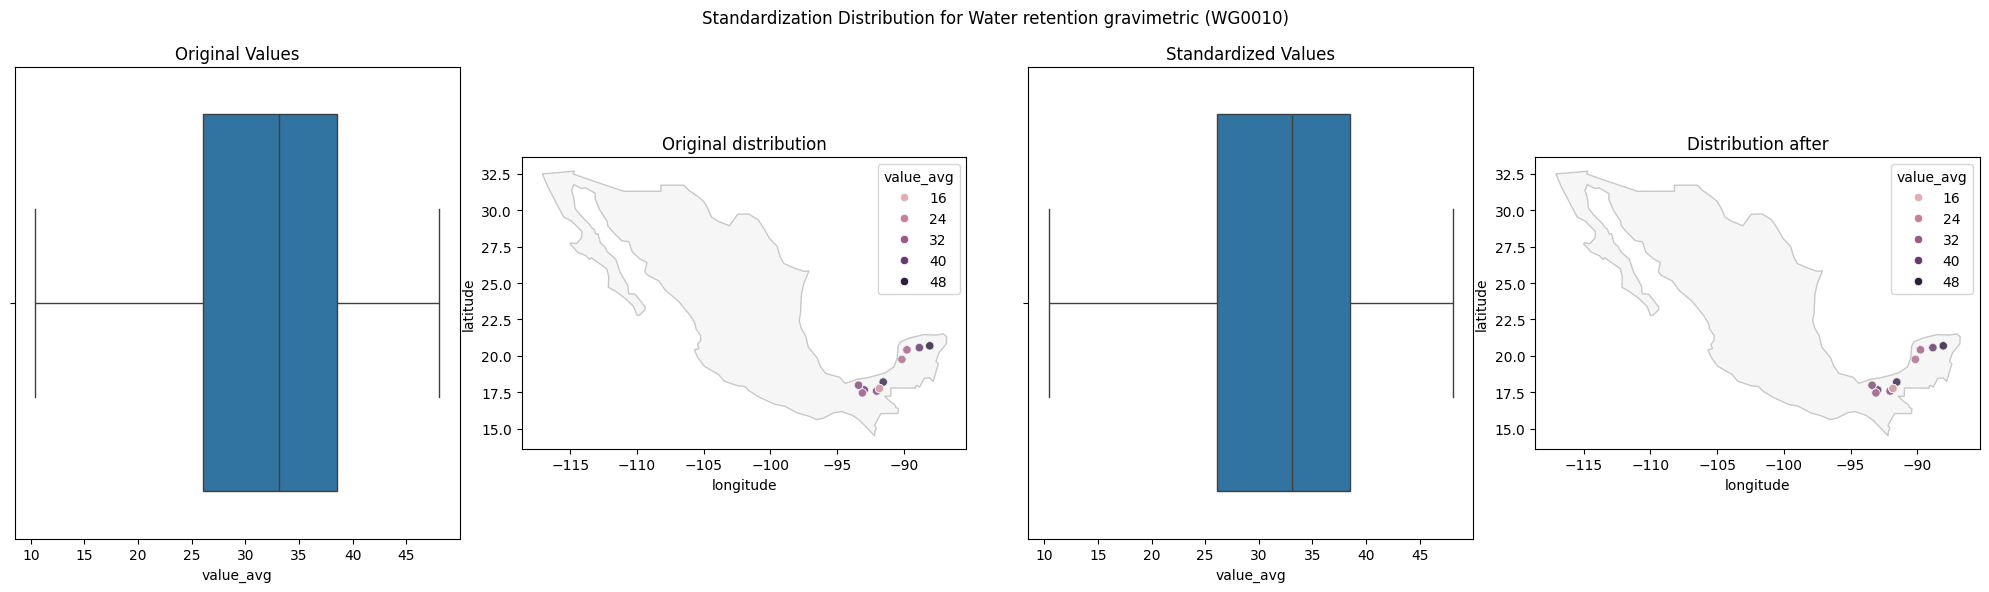

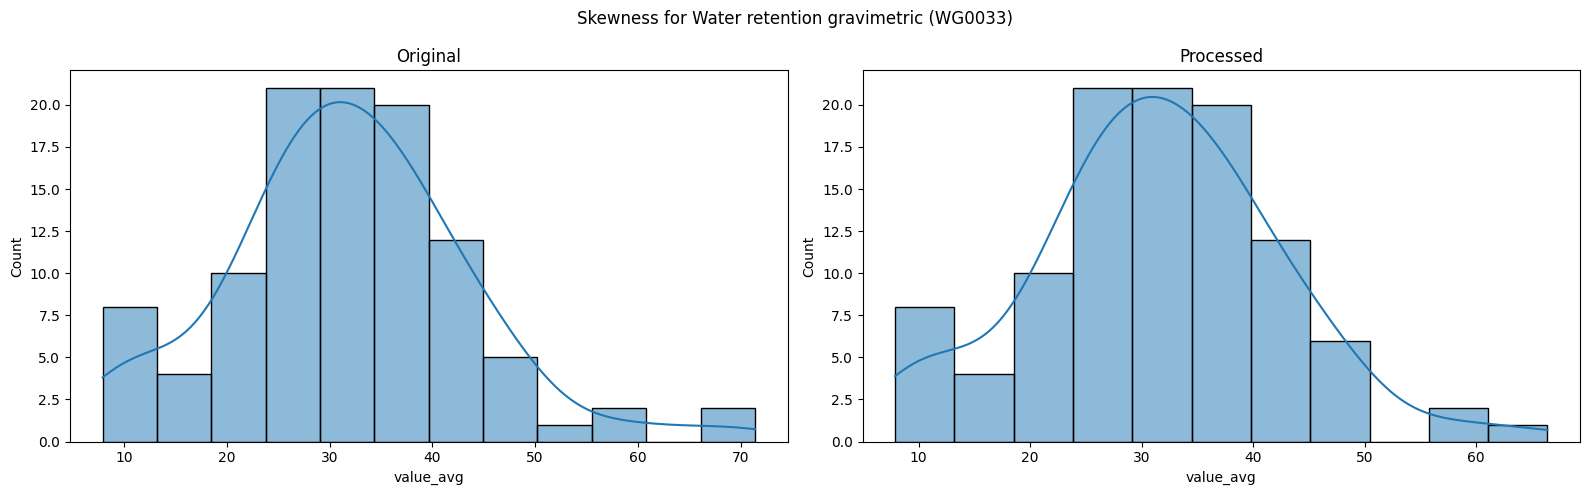

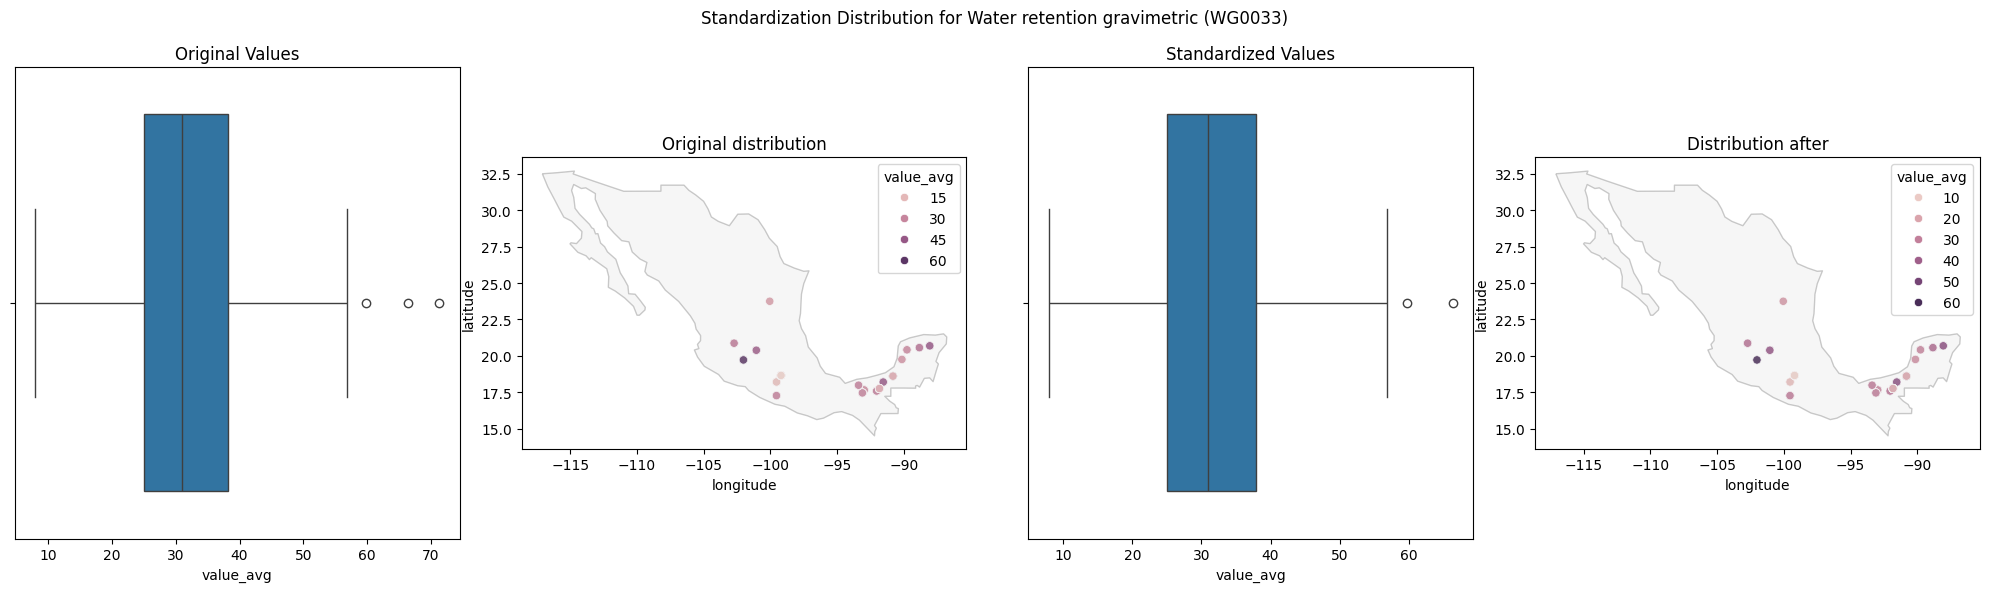

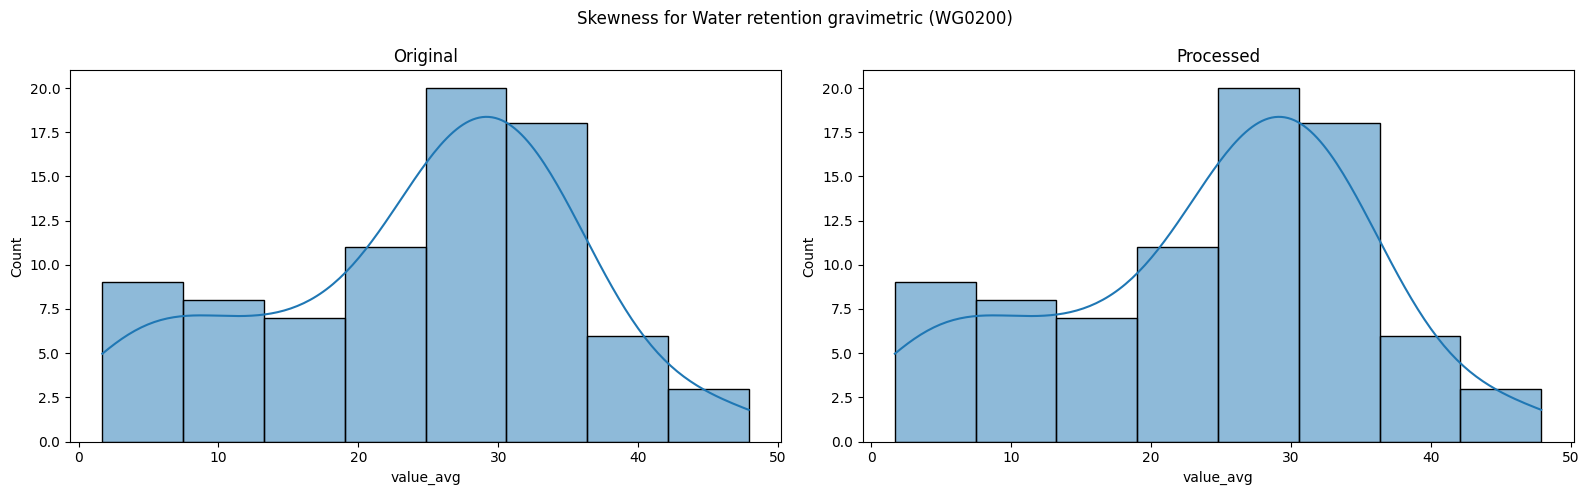

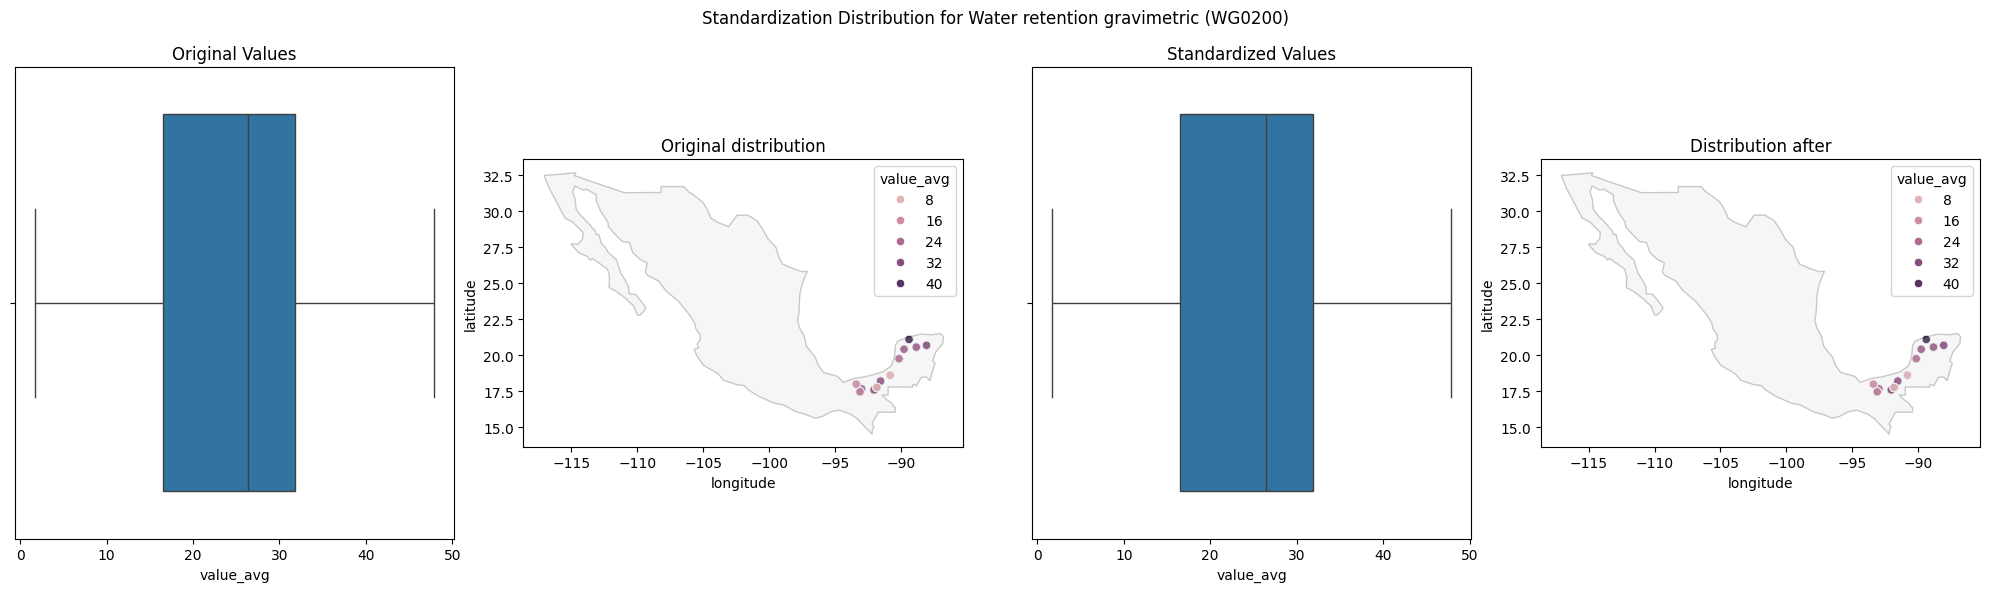

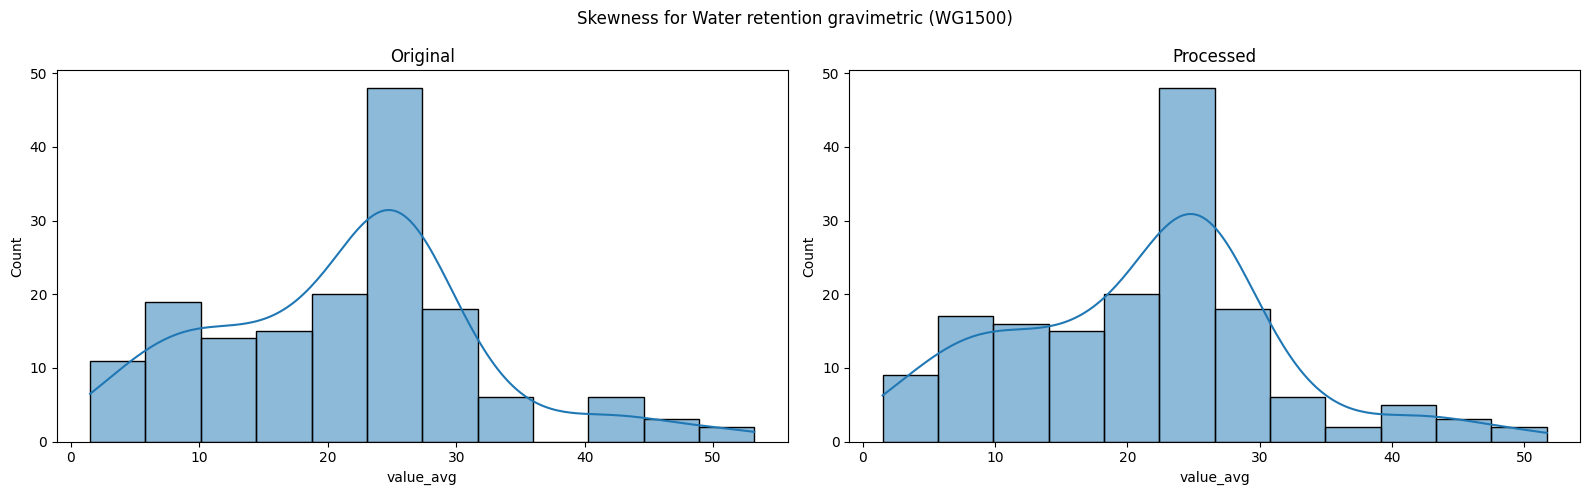

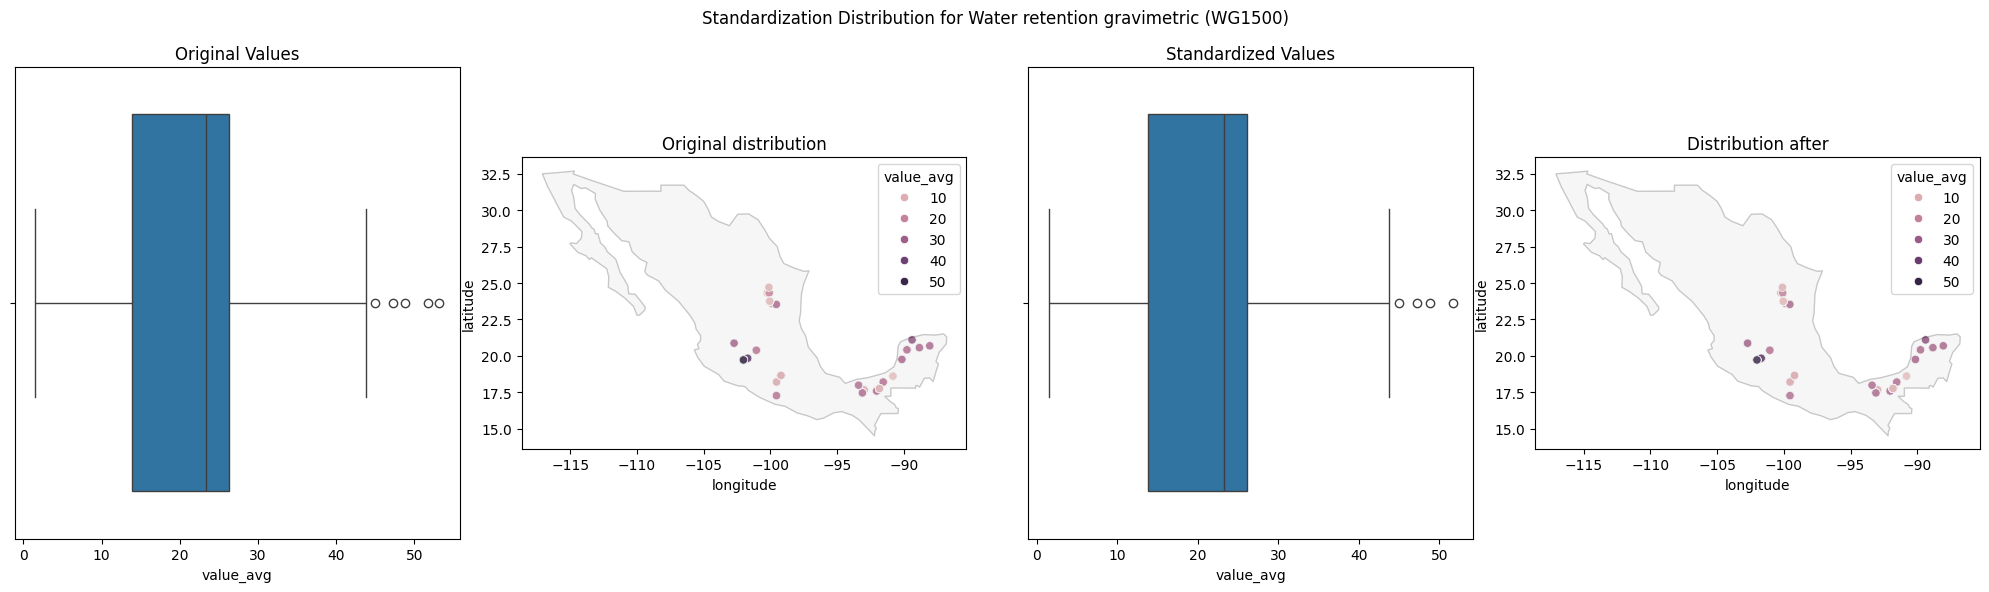

In [34]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

def processed_dataset(code):
    property = get_property_by_code(code)
    df = pd.read_csv(f'{base_path}{code.lower()}.tsv', sep='\t')  
    df = filter_by_country(df, 'Mexico')
    
    df = df[['profile_id', 'latitude', 'longitude', 'value_avg']]
    df_original = df.copy()

    # drop missing values
    df = df.dropna()

    # remove negative values
    df = df[df['value_avg'] >= 0]

    # remove outliers using z-score
    z_scores = np.abs(stats.zscore(df['value_avg']))
    df = df[z_scores < 3]

    # standardise the values
    # scaler = StandardScaler()
    # df['value_avg'] = scaler.fit_transform(df['value_avg'].values.reshape(-1, 1))

    # remove outliers using IQR
    # Q1 = df['value_avg'].quantile(0.25)
    # Q3 = df['value_avg'].quantile(0.75)
    # IQR = Q3 - Q1
    # df = df[(df['value_avg'] >= Q1 - 1.5 * IQR) & (df['value_avg'] <= Q3 + 1.5 * IQR)]

    return df_original, df, property

def distribution(code):
    df_original, df, property = processed_dataset(code)

    # plot the skewness
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.histplot(df_original['value_avg'], kde=True)
    plt.title('Original')

    plt.subplot(1,2,2)
    sns.histplot(df['value_avg'], kde=True)
    plt.title('Processed')

    plt.suptitle(f'Skewness for {property}')
    plt.tight_layout()
    plt.show()

    # Plotting side by side
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))

    # Box plot for the original values
    sns.boxplot(x=df_original['value_avg'], ax=ax[0])
    ax[0].set_title('Original Values')

    # Scatter plot for distribution before
    sns.scatterplot(data=df_original, x='longitude', y='latitude', hue='value_avg', ax=ax[1])
    ax[1].set_title('Original distribution')
    mexico_shape.plot(ax=ax[1], color='lightgray', edgecolor='black', alpha=0.2)

    # Box plot for the standardized values
    sns.boxplot(x=df['value_avg'], ax=ax[2])
    ax[2].set_title('Standardized Values')

    # Scatter plot for distribution after
    sns.scatterplot(data=df, x='longitude', y='latitude', hue='value_avg', ax=ax[3])
    ax[3].set_title('Distribution after')
    mexico_shape.plot(ax=ax[3], color='lightgray', edgecolor='black', alpha=0.2)

    plt.suptitle(f'Standardization Distribution for {property}')
    plt.tight_layout()
    plt.savefig(f'outputs/plots/distribution_{property}.png')
    plt.show()

for code in valid_codes:
    distribution(code)

### Creating a dataframe for analysis
- We are left with 7 properties for analysis.  
- We will create a dataframe with the mean of the values for each property.  
- Look for missing values and impute them.  



In [ ]:
from shapely.geometry import Point

column_names = ['CLAY', 'ELCOSP', 'PHAQ', 'SAND', 'SILT', 'TCEQ', 'ORGC']

# Initialize an empty GeoDataFrame
mexico_dataframe = gpd.GeoDataFrame()

for code in column_names:
    # Get the dataset for each property
    original_df, df, property = processed_dataset(code)  # df should contain profile_id, latitude, longitude, value_avg
    
    # Group by profile_id, latitude, longitude to calculate mean of value_avg for each property
    mean_df = df.groupby(['profile_id', 'latitude', 'longitude'])['value_avg'].mean().reset_index()
    
    mean_df = mean_df.rename(columns={'value_avg': code})
    
    if mexico_dataframe.empty:
        mexico_dataframe = mean_df
    else:
        mexico_dataframe = mexico_dataframe.merge(mean_df, on=['profile_id', 'latitude', 'longitude'], how='outer')

# create geometry
mexico_dataframe['Geometry'] = mexico_dataframe.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# convert to geodataframe
mexico_dataframe = gpd.GeoDataFrame(mexico_dataframe, geometry='Geometry')

# rename columns
mexico_dataframe = mexico_dataframe.rename(columns={'profile_id': 'ID'})
mexico_dataframe.to_file("data/mexico/mexico_dataframe.geojson", driver='GeoJSON')
mexico_dataframe.to_csv("data/mexico/mexico_dataframe.csv", index=False)

mexico_dataframe.head()

In [ ]:
# visualise missing values
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].set_title('Missing Values')
sns.heatmap(mexico_dataframe.isnull(), cbar=False, cmap='viridis', ax=ax[0])

imputed = mexico_dataframe.copy()
deleted = mexico_dataframe.copy()
# simple imputation on selected columns
for column in column_names:
    imputed[column] = imputed[column].fillna(imputed[column].mean())

# delete missing values
deleted = deleted.dropna()

# plot bar graph of total records
plt.bar(['Original', 'Imputed', 'Deleted'], [len(mexico_dataframe), len(imputed), len(deleted)])
ax[1].set_title('Stats after imputation and deletion')

plt.tight_layout()
plt.show()

### Missing values
- We have 90% missing values for TCEQ. __Is this a valid property?__
- We have 80% missing values for ORGC. which is our target variable.

If we delete the missing values we are left with little over 2000 records.  
If we impute the missing values we will have over 7000 records but TCEQ will not be a valid variable.


### Correlation matrix
- We can see that ORGC shows small correlation with SILT and SAND.
- The strongest correlation is between PHAQ and TCEQ. __Will dropping TCEQ help?__

In [ ]:
# correlation matrix for imputed on selected columns
corr_matrix = imputed[column_names].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Imputed Data on Selected Columns')
plt.show()

### Spatial weights
- We will use contiguity weights only on ORGC.



In [ ]:
spatial_df = imputed[['Geometry', 'ORGC']].copy()
w = weights.contiguity.Queen.from_dataframe(spatial_df)
w.transform = 'r' # row-standardised
plot_spatial_weights(w, spatial_df)
plt.title('Spatial Weights Visualization')
plt.show()

### Spatial Lag
- We can see that ORGC is clustered in the midlands and south of the country.
- We can see that ORGC is high in the south and low in the north.



In [ ]:
import libpysal as lps
import mapclassify as mc

# plot the data using quantiles
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title(f'ORGC using Quantiles')
imputed.plot(column='ORGC', scheme='Quantiles', k=5, cmap='viridis', legend=True, ax=ax[0]);

# spatial lag
y = imputed['ORGC']
ylag = lps.weights.lag_spatial(w, y)

ylagq5 = mc.Quantiles(ylag, k=5)

imputed.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, k=5, cmap='viridis', linewidth=0.1, ax=ax[1], edgecolor='white', legend=True)
ax[1].set_title(f"Spatial Lag ORGC (Quantiles)")

plt.tight_layout()
plt.show()

### Moran's I


In [ ]:
for code in column_names:
    # Moran's I for global correlation
    moran = Moran(imputed[code], w)

    # plot Moran's I for features
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    moran_scatterplot(moran, imputed[code], p=True, aspect_equal=True, ax=ax[0])
    ax[0].set_title(f'Moran\'s I for {code}: {moran.I:.2f} (p-value={moran.p_sim})')

    # Local Moran's I
    local_moran = Moran_Local(imputed[code], w)

    # Plotting Local Moran's I scatterplot of pop_count
    # high value with high value neighbors (HH);
    # low value with low value neighbors (LL);
    # high value with low value neighbors (HL);
    # low value with high value neighbors (LH).
    moran_scatterplot(local_moran, imputed[code], p=True, aspect_equal=True, ax=ax[1])
    ax[1].set_title(f'Local Moran\'s I for {code}')
    ax[1].legend(['HH', 'HL', 'LH', 'LL'], title='Legend', loc='upper right')

    # creating column with local_moran classification
    imputed[f'{code}_local_moran'] = local_moran.q

    plt.suptitle(f'Moran\'s I and Local Moran\'s I for {code}')
    plt.tight_layout()
    plt.show()

In [ ]:
imputed.head()

In [29]:
sig = local_moran.p_sim < 0.05
hotspot = sig * local_moran.q==1
coldspot = sig * local_moran.q==3
doughnut = sig * local_moran.q==2
diamond = sig * local_moran.q==4

In [30]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

In [ ]:
from matplotlib import colors

df = imputed.copy()

hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Local Moran\'s Hotspots for ORGC')
plt.show()

### Hotspots
- We can see that ORGC is high in the south and low in the north.


In [ ]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

df = imputed.copy()
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Local Moran\'s Coldspots for ORGC')
plt.show()

### Coldspots
- We can see that ORGC is low in the south and high in the north.


In [ ]:
imputed.explore(
    tiles='cartodbpositron',
    column='ORGC_local_moran',
    m=mexico_map,
    height='70%',
    width='70%',
    colors=['#D7191C', '#FDAE61', '#ABD9E9','#2C7BB6','#D3D3D3'],
    style_kwds={
        'stroke': True,
        'edgecolor': 'k',
        'linewidth': 0.03,
        'fillOpacity': 1
        
        },
    )

In [34]:
# from shapely.geometry import Polygon

# lat_point_list = imputed['latitude'].tolist()
# long_point_list = imputed['longitude'].tolist()

# polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
# polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       

# polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
# polygon.to_file(filename='polygon.gpkg', driver="GPKG")
# polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

In [35]:
# import folium
# m = folium.Map([50.854457, 4.377184], zoom_start=5, tiles='cartodbpositron')
# folium.GeoJson(polygon).add_to(m)
# folium.LatLngPopup().add_to(m)
# m
# # if using Spyder.5
# import webbrowser
# m.save('test.html')
# webbrowser.open_new_tab('test.html')